# **Vállalati ügyfelek elemzése az értékesítési dokumentumok alapján**

Készítette: Fischer Anna és Póra Boglárka, Üzleti és pénzügyi adattan, 2024

## **Projekt céljai:**


*   Rendelkezésre álló adatok felfedezése és modellezhető formára hozása
*   FRM analízis végrehajtása
*   Ügyfélklaszterek kialakítása
*   Eredmények alapján stratégiák javaslása


## **Adatok leírása:**



*   DocumentId - Az értékesítési dokumentum száma, egyedi azonosító - text
*   PartnerId - A kereskedelmi partner (ügyfél) egyedi azonosítója - text
*   DocumentDate - Az értékesítési dokumentum dátuma - date
*   City - A kereskedelmi partner (ügyfél) székhelye - text
*   Sales - Az értékesítési dokumentum (számla) értéke - numeric




## **Metodológia:**


*   Felfedező adatelemzés (Exploratory Data Analysis)
*   FRM analízis
*   Klaszterezési algoritmusok
*   Dimenziócsökkentési algoritmusok
*   Interaktív vizualizációs technikák




## **Könyvtárak importálása és színpaletta kiválasztása**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("rocket")

In [ ]:
sns.color_palette()

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

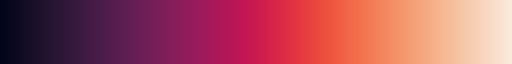

In [ ]:
sns.color_palette("rocket", as_cmap = True)

In [ ]:
palette = sns.color_palette()
c_palette = sns.color_palette("rocket", as_cmap = True)

## **Adatok beolvasása**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Big Data Adatelemzes/data.xlsx')
data.head()

DocumentId  PartnerId DocumentDate                  City     Sales
0      822217        331   2022-09-27                BRASOV -79375.42
1      821727      12508   2022-08-01                   NaN  -4345.24
2      840424       8939   2022-12-20             TIMISOARA  -2952.60
3      758393       1098   2022-01-11  BUCURESTI SECTORUL 6  -2428.48
4      830027       7569   2022-10-28             TIMISOARA  -2205.90

In [ ]:
# Vagy
#data = pd.read_excel('data.xlsx')
#data.head()

## **Adatfelfedezés és tisztítás**

In [ ]:
data.columns

Index(['DocumentId', 'PartnerId', 'DocumentDate', 'City', 'Sales'], dtype='object')

In [ ]:
data.shape

(9818, 5)

Amint láthatjuk, az elemzésre szánt adatsor 9818 sorból és 5 oszlopból áll.

In [ ]:
data.dtypes

DocumentId               int64
PartnerId                int64
DocumentDate    datetime64[ns]
City                    object
Sales                  float64
dtype: object

Láthatjuk a dimenziók adattípusait, az int, float és datetime típusok megjelenése előre jelzi, hogy nincsenek olyan hibás értékek az adatsorban, amelyek miatt object típusúvá válna egy oszlop, de még mindig lehetnek hiányzó értékek.

In [ ]:
data.describe()

DocumentId     PartnerId                   DocumentDate  \
count    9818.000000   9818.000000                           9818   
mean   799375.430739   6961.042575  2022-06-29 09:40:39.845182464   
min    756724.000000      4.000000            2022-01-03 00:00:00   
25%    776993.250000   1141.000000            2022-04-05 00:00:00   
50%    800005.000000   8191.000000            2022-06-30 00:00:00   
75%    821269.750000  10961.000000            2022-09-22 00:00:00   
max    843594.000000  12812.000000            2022-12-30 00:00:00   
std     25175.856289   4416.929374                            NaN   

              Sales  
count   9818.000000  
mean     829.039757  
min   -79375.420000  
25%      270.475000  
50%      588.165000  
75%     1027.402500  
max    24313.420000  
std     1446.307460

DocumentId és PartnerId numerikusként jelennek meg, azonban nincs értelme a fenti metrikáknak ezekre a változókra. Azonban innen könnyen láthatjuk például, hogy:


*   Az eladások a 2022-es évet fedik le
*   Vannak negatív értékű számlák is, mivel a min érték az egész adatsorra -79375.42



In [ ]:
data.duplicated().sum()

0

Ez azt mutatja, hogy nincs ismétlődő sorunk az adatkeretben.

A következő lépés, hogy a dimenziókat sorra véve leellenőrizzük és megtisztítsuk az oda nem illő értékektől, vagy kiegészítsük a hiányzó értékeket.

**DocumentId**

In [ ]:
data['DocumentId'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9818 entries, 0 to 9817
Series name: DocumentId
Non-Null Count  Dtype
--------------  -----
9818 non-null   int64
dtypes: int64(1)
memory usage: 76.8 KB


In [ ]:
data['DocumentId'].nunique()

9818

Ugyanannyi egyedi érték vannak ebben az oszlopban, ahány sora van az adatsornak, tehát nincsenek ismétlődő dokument azonosítók.

In [ ]:
data['DocumentId'].isna().any()

False

A változó értékei közül nem hiányzik egy sem.

Mivel ez egy egyéni azonosító, így nem fogjuk felhasználni a feature engineering folyamat során, hisz nem mutat plusz információt az adott számlasorról, mivel egyedi érték, csak azonosításra van.

**PartnerId**

In [ ]:
data['PartnerId'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9818 entries, 0 to 9817
Series name: PartnerId
Non-Null Count  Dtype
--------------  -----
9818 non-null   int64
dtypes: int64(1)
memory usage: 76.8 KB


In [ ]:
data['PartnerId'].nunique()

814

Tudjuk, hogy a vállalat 2022-ben 814 különböző ügyfélnek számlázott.

In [ ]:
data['PartnerId'].isna().any()

False

Egy számlán sem felejtették el feltüntetni a klienst.

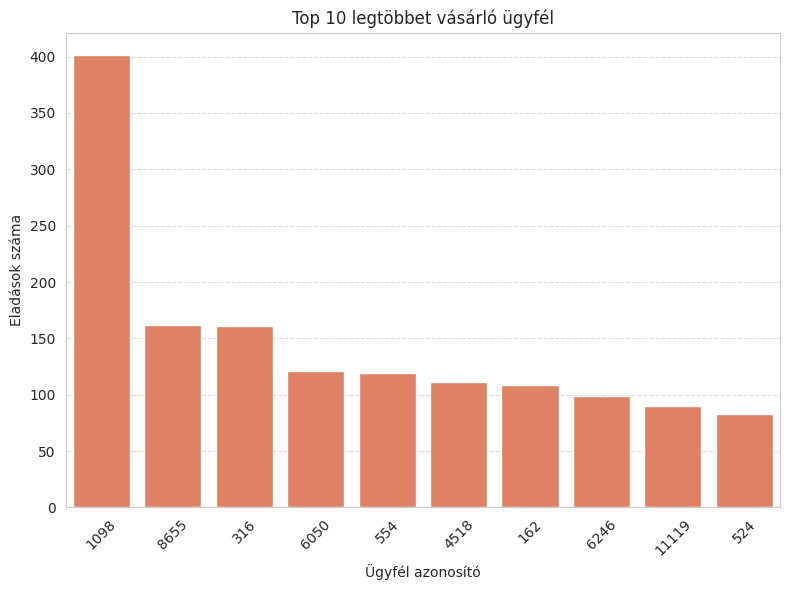

In [ ]:
partner_counts = data['PartnerId'].value_counts()
top_10_partners = partner_counts.head(10).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_10_partners.index, y=top_10_partners.values, color=palette[4], order=top_10_partners.index)

plt.title('Top 10 legtöbbet vásárló ügyfél')
plt.xlabel('Ügyfél azonosító')
plt.ylabel('Eladások száma')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Erről az ábráról könnyen leolvashatjuk, hogy melyik ügyfelek a legaktívabb vásárlói a vállalatunknak, és hogy hány-hány számla lett kiállítva nekik.

**DocumentDate**

In [ ]:
data['DocumentDate'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9818 entries, 0 to 9817
Series name: DocumentDate
Non-Null Count  Dtype         
--------------  -----         
9818 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 76.8 KB


In [ ]:
data['DocumentDate'].nunique()

250

Az év 250 napján történt a vállalatnál értékesítés.

In [ ]:
data['DocumentDate'].isna().any()

False

A dátumok sem hiányoznak egyik számláról sem.

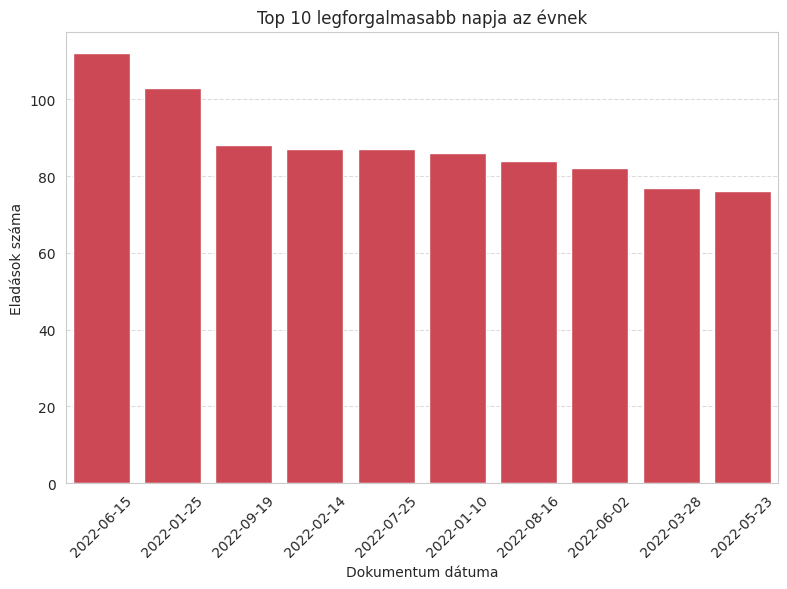

In [ ]:
day_counts = data['DocumentDate'].value_counts()
top_10_days = day_counts.head(10).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_10_days.index, y=top_10_days.values, color=palette[3], order=top_10_days.index)

plt.title('Top 10 legforgalmasabb napja az évnek')
plt.xlabel('Dokumentum dátuma')
plt.ylabel('Eladások száma')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Eléggé változó, hogy az év melyik időszakában vannak a legjövedelmezőbb napok.

**City**

In [ ]:
data['City'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9818 entries, 0 to 9817
Series name: City
Non-Null Count  Dtype 
--------------  ----- 
9807 non-null   object
dtypes: object(1)
memory usage: 76.8+ KB


In [ ]:
data['City'].nunique()

256

256 különböző településen van a székhelyük a vállalat ügyfeleinek.

In [ ]:
data['City'].isna().any()

True

In [ ]:
data['City'].isna().sum()

11

A székhely dimenzió esetén már vannak hiányzó értékek (pontosabban 11), meg kell néznünk, hogy melyek ezek.

In [ ]:
data[data['City'].isna()]

DocumentId  PartnerId DocumentDate City     Sales
1         821727      12508   2022-08-01  NaN  -4345.24
795       801975       7863   2022-07-08  NaN     81.59
1524      814134       7863   2022-07-27  NaN    165.59
4032      784554       7863   2022-05-05  NaN    457.11
6686      822062      12508   2022-09-01  NaN    879.46
6871      820064       7863   2022-09-16  NaN    912.08
7569      797966       7863   2022-05-04  NaN   1080.40
9401      761887       9179   2022-01-26  NaN   2486.83
9602      797970       7863   2022-05-05  NaN   3104.35
9697      814595      12508   2022-07-18  NaN   4345.24
9785      796390      12414   2022-06-02  NaN  11072.32

Először leellenőrizhetjük, hogy véletlenül egy másik, ahhoz a partnerhez tartozó számlán megjelenik-e a székhely, és ezeken csak véletlenül maradt le.

In [ ]:
data[data['PartnerId'] == 12508]

DocumentId  PartnerId DocumentDate City    Sales
1         821727      12508   2022-08-01  NaN -4345.24
6686      822062      12508   2022-09-01  NaN   879.46
9697      814595      12508   2022-07-18  NaN  4345.24

In [ ]:
data[data['PartnerId'] == 7863]

DocumentId  PartnerId DocumentDate City    Sales
795       801975       7863   2022-07-08  NaN    81.59
1524      814134       7863   2022-07-27  NaN   165.59
4032      784554       7863   2022-05-05  NaN   457.11
6871      820064       7863   2022-09-16  NaN   912.08
7569      797966       7863   2022-05-04  NaN  1080.40
9602      797970       7863   2022-05-05  NaN  3104.35

In [ ]:
data[data['PartnerId'] == 9179]

DocumentId  PartnerId DocumentDate City    Sales
9401      761887       9179   2022-01-26  NaN  2486.83

In [ ]:
data[data['PartnerId'] == 12414]

DocumentId  PartnerId DocumentDate City     Sales
9785      796390      12414   2022-06-02  NaN  11072.32

Sajnos semmilyen esetben sem jelenik meg székhely, ezért azt tudjuk tenni, hogy Ismeretlen-re állítjuk be ezen értékeket.

In [ ]:
data['City'].fillna('Unknown', inplace=True)

In [ ]:
data[data['City'] == 'Unknown']

DocumentId  PartnerId DocumentDate     City     Sales
1         821727      12508   2022-08-01  Unknown  -4345.24
795       801975       7863   2022-07-08  Unknown     81.59
1524      814134       7863   2022-07-27  Unknown    165.59
4032      784554       7863   2022-05-05  Unknown    457.11
6686      822062      12508   2022-09-01  Unknown    879.46
6871      820064       7863   2022-09-16  Unknown    912.08
7569      797966       7863   2022-05-04  Unknown   1080.40
9401      761887       9179   2022-01-26  Unknown   2486.83
9602      797970       7863   2022-05-05  Unknown   3104.35
9697      814595      12508   2022-07-18  Unknown   4345.24
9785      796390      12414   2022-06-02  Unknown  11072.32

In [ ]:
data['City'].isna().any()

False

Mostmár eltűntek a hiányzó értékek.

Ezután viszont meg kell vizsgálnunk, hogy vannak-e olyan városnevek, amelyek apró elírások miatt külön városként jelennek meg, azonban ugyanarról a településről van szó. Ezeket egyforma alakra kell hozni.

In [ ]:
unique_cities = sorted(data['City'].unique())
for city in unique_cities:
    print(city)

ADEA
AGHIRESU-FABRICI
AIUD
ALBA IULIA
ALBA-IULIA
ALBESTI
AMARA
ANDRID
ARAD
ARMENIS
BACAU
BACIU
BAIA DE FIER
BAIA MARE
BAIA SPRIE
BAILE HERCULANE
BAILE TUSNAD
BARLAD
BARZAVA
BECICHERECU MIC
BECLEAN
BEIUS
BELOBRESCA
BICAZ
BISTRITA
BIVOLARIA
BODOC
BOLDESTI-SCAENI
BORLOVA
BORSA
BORSEC
BOTOSANI
BRAD
BRADESTI
BRANCOVENESTI
BRASOV
BREAZU
BREBU NOU
BRODINA
BUCURESTI
BUCURESTI SECTORUL 1
BUCURESTI SECTORUL 2
BUCURESTI SECTORUL 3
BUCURESTI SECTORUL 4
BUCURESTI SECTORUL 5
BUCURESTI SECTORUL 6
BUDAPESTA
BUFTEA
BUMBESTI-JIU
BUZAU
BUZIAS
CALIMANESTI
CAMPU LUI NEAG
CAMPULUNG
CAPALNITA
CARACAL
CARANSEBES
CARASOVA
CAREI
CERASU
CHEIA
CHICHIS
CHISINEU-CRIS
CICEU-MIHAIESTI
CLUJ
CLUJ NAPOCA
CLUJ-NAPOCA
CODLEA
COMANESTI
CONSTANTA
CORNESTI
CORUNCA
CORUND
COVASNA
COZMENI
CRAIOVA
CRISTESTI
CRISTURU SECUIESC
CUCORANI
CURTICI
DANESTI
DARABANI
DARMANESTI
DEJ
DETA
DEVA
DOLJ
DRAGOMIRESTI
DRAMBAR
DROBETA TURNU SEVERIN
DUDESTII VECHI
DUMBRAVA ROSIE
DUMBRAVITA
FAGARAS
FALTICENI
FELDIOARA
FELICENI
FILIASI
FLORESTI
FOCS

A városnevekből kivesszük a kötőjeleket:

In [ ]:
data['City'] = data['City'].str.replace('-', ' ')

A Bukarest különböző szektoraiban elhelyezkedő székhelyeket általánosan Bukarestre változtatjuk, hogy érzékeltessük, hogy az össz bukaresti cégek számát:

In [ ]:
data['City'] = data['City'].str.replace(r'(.*)BUCURESTI SECTORUL(.*)', r'BUCURESTI', regex=True)

A következő változtatások különböző városmegnevezéseket korrigálnak vagy ahol csak megye megnevezés van, oda azt írjuk hogy ismeretlen a város:

In [ ]:
mask = data['City'] == 'CLUJ'
data.loc[mask, 'City'] = 'CLUJ Unknown City'

mask = data['City'] == 'HARGHITA'
data.loc[mask, 'City'] = 'HARGHITA Unknown City'

data['City'] = data['City'].str.replace('OD SECUIESC', 'ODORHEIU SECUIESC')
data['City'] = data['City'].str.replace('ODORHEIUL SECUIESC', 'ODORHEIU SECUIESC')

data['City'] = data['City'].str.replace('TG MURES', 'TARGU MURES')

data.loc[data['City'].str.contains('^TIMIS$', regex=True), 'City'] = 'TIMIS Unknown City'

data['City'] = data['City'].str.replace('TG SECUIESC', 'TARGU SECUIESC')

data['City'] = data['City'].str.replace(r'\s+', ' ', regex=True)

data['City'] = data['City'].str.replace(r'(.*)(GHEORGHE)(.*)', r'SFANTU GHEORGHE', regex=True)

In [ ]:
unique_cities = sorted(data['City'].unique())
for city in unique_cities:
    print(city)

ADEA
AGHIRESU FABRICI
AIUD
ALBA IULIA
ALBESTI
AMARA
ANDRID
ARAD
ARMENIS
BACAU
BACIU
BAIA DE FIER
BAIA MARE
BAIA SPRIE
BAILE HERCULANE
BAILE TUSNAD
BARLAD
BARZAVA
BECICHERECU MIC
BECLEAN
BEIUS
BELOBRESCA
BICAZ
BISTRITA
BIVOLARIA
BODOC
BOLDESTI SCAENI
BORLOVA
BORSA
BORSEC
BOTOSANI
BRAD
BRADESTI
BRANCOVENESTI
BRASOV
BREAZU
BREBU NOU
BRODINA
BUCURESTI
BUDAPESTA
BUFTEA
BUMBESTI JIU
BUZAU
BUZIAS
CALIMANESTI
CAMPU LUI NEAG
CAMPULUNG
CAPALNITA
CARACAL
CARANSEBES
CARASOVA
CAREI
CERASU
CHEIA
CHICHIS
CHISINEU CRIS
CICEU MIHAIESTI
CLUJ NAPOCA
CLUJ Unknown City
CODLEA
COMANESTI
CONSTANTA
CORNESTI
CORUNCA
CORUND
COVASNA
COZMENI
CRAIOVA
CRISTESTI
CRISTURU SECUIESC
CUCORANI
CURTICI
DANESTI
DARABANI
DARMANESTI
DEJ
DETA
DEVA
DOLJ
DRAGOMIRESTI
DRAMBAR
DROBETA TURNU SEVERIN
DUDESTII VECHI
DUMBRAVA ROSIE
DUMBRAVITA
FAGARAS
FALTICENI
FELDIOARA
FELICENI
FILIASI
FLORESTI
FOCSANI
FRUMOASA
GALATI
GHIDFALAU
GHIMBAV
GHIRODA
GIARMATA VII
GIROC
GORNESTI
HALCHIU
HARGHITA Unknown City
HARLAU
HARMAN
HATEG
HUEDIN
HUNED

Láthatjuk, hogy csak az egyedi településnevek maradtak az adattáblában.

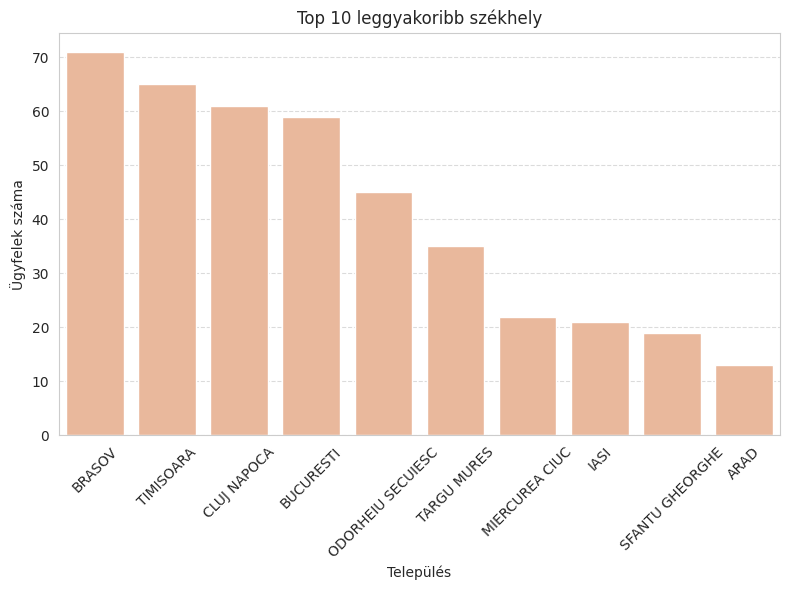

In [ ]:
cities = data.drop_duplicates(subset=['PartnerId', 'City'])

city_counts = cities['City'].value_counts()

top_10_city = city_counts.head(10).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_10_city.index, y=top_10_city.values, color=palette[5], order=top_10_city.index)

plt.title('Top 10 leggyakoribb székhely')
plt.xlabel('Település')
plt.ylabel('Ügyfelek száma')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Vállalatunk legtöbb partnere brassói székhelyű.

**Sales**

In [ ]:
data['Sales'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9818 entries, 0 to 9817
Series name: Sales
Non-Null Count  Dtype  
--------------  -----  
9818 non-null   float64
dtypes: float64(1)
memory usage: 76.8 KB


Mivel float az adattípusa, így biztos csak számok szerepelnek a változó értékei között, nem vegyült be valamilyen elírás.

In [ ]:
data['Sales'].isna().any()

False

In [ ]:
data.dtypes

DocumentId               int64
PartnerId                int64
DocumentDate    datetime64[ns]
City                    object
Sales                  float64
dtype: object

Az számlaértékek között nincsenek hiányzó értékek.

In [ ]:
data[data['Sales'] <= 0]

DocumentId  PartnerId DocumentDate            City     Sales
0        822217        331   2022-09-27          BRASOV -79375.42
1        821727      12508   2022-08-01         Unknown  -4345.24
2        840424       8939   2022-12-20       TIMISOARA  -2952.60
3        758393       1098   2022-01-11       BUCURESTI  -2428.48
4        830027       7569   2022-10-28       TIMISOARA  -2205.90
..          ...        ...          ...             ...       ...
338      833782       1720   2022-11-15         SACALAZ      0.00
339      840442       7330   2022-12-20  MIERCUREA CIUC      0.00
340      840444       8813   2022-12-20  MIERCUREA CIUC      0.00
341      840817       1804   2022-12-23       TIMISOARA      0.00
342      841065      11246   2022-12-27         IZVOARE      0.00

[343 rows x 5 columns]

Itt azonban láthatjuk, hogy a számláknak lehet negatív értékük is.

Ezek a következő esetek miatt lehetnek:


*   Stornó számla: a kliens visszaküldte a terméket
*   A kliens előleg számla alapján kifizette a teljes értéket
*   Termék leszámlázása ugyanakkora értékű kedvezménnyel
*   Sok vásárlás esetén utólagos kedvezményadás
*   Egyéb

Ezen okok miatt, ezek a számlák nem tekinthetők külön vásárlásoknak, így nem fogják a további elemzésünk részét képezni.

In [ ]:
data_pos = data[data['Sales'] > 0]

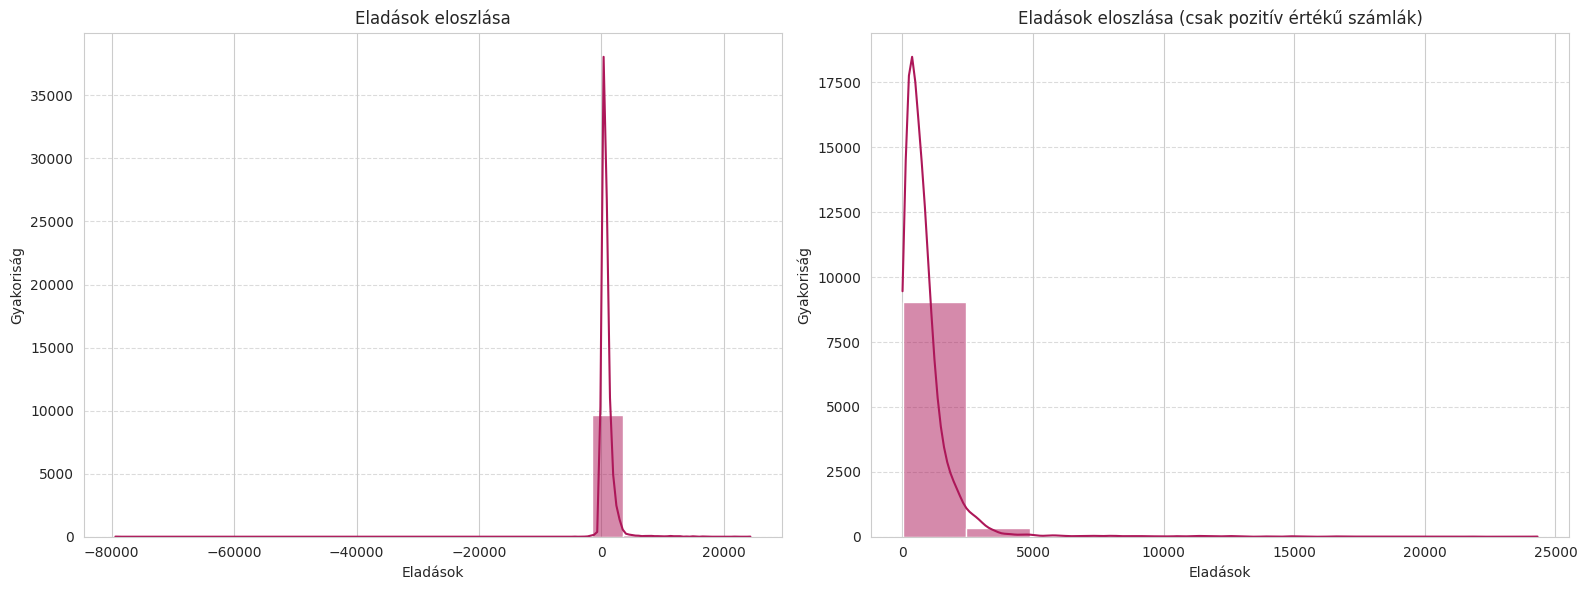

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data['Sales'], kde=True, bins=20, color=palette[2], ax=axs[0])
axs[0].set_title('Eladások eloszlása')
axs[0].set_xlabel('Eladások')
axs[0].set_ylabel('Gyakoriság')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.histplot(data_pos['Sales'], kde=True, bins=10, color=palette[2], ax=axs[1])
axs[1].set_title('Eladások eloszlása (csak pozitív értékű számlák)')
axs[1].set_xlabel('Eladások')
axs[1].set_ylabel('Gyakoriság')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Láthatjuk, hogy az értékek eloszlása nagy mértékben változik azzal, hogy a negatív és 0 értékű számlákat eltávolítottuk, azonban ez szükséges lépés volt. Ez az ábra már sejteti az outlier értékek jelenlétét is, amelyekkel modellezés előtt ugyancsak kell foglalkozni.

In [ ]:
data = data_pos

In [ ]:
data.shape

(9475, 5)

Maradtunk 9475 elemezendő számlasorral.

In [ ]:
data.head()

DocumentId  PartnerId DocumentDate       City  Sales
343      779058      10592   2022-04-13     BRASOV   6.42
344      829740      12054   2022-10-27      GIROC   6.83
345      829748      12593   2022-10-27    CORUNCA   6.83
346      781716      11567   2022-04-26  BUCURESTI  10.90
347      803442        162   2022-07-14     SOVATA  11.76

## **Felfedező Adatelemzés (EDA)**

Ebben a fejezetben egy kicsit jobban felfedezzük az adatokban rejlő potenciális mintákat.

**Eladások Negyedéves Alakulása**

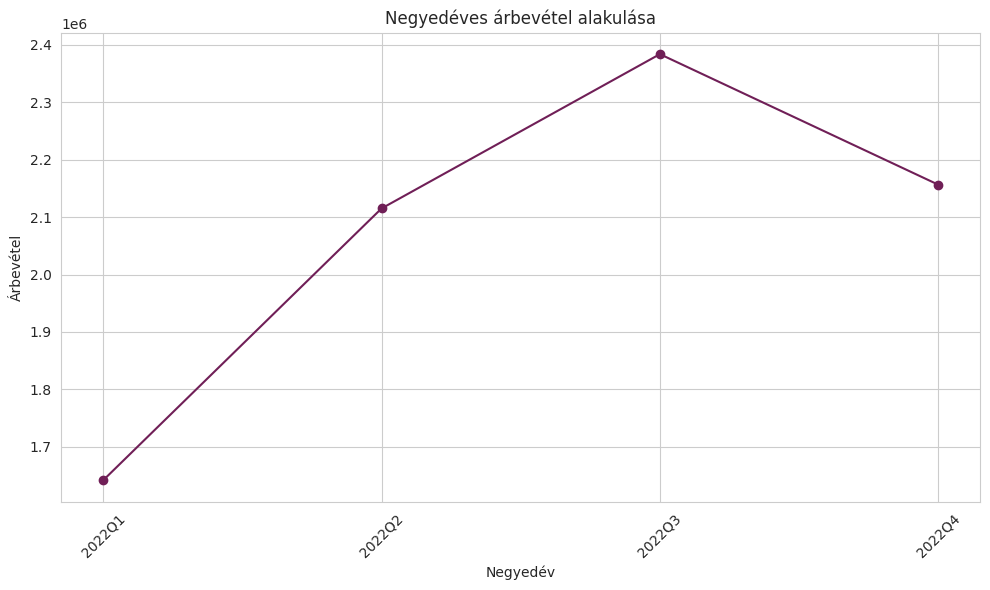

In [ ]:
data['Quarter'] = data['DocumentDate'].dt.to_period('Q')
quarterly_sales = data.groupby('Quarter')['Sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(quarterly_sales['Quarter'].astype(str), quarterly_sales['Sales'], marker='o', color=palette[1])
plt.title('Negyedéves árbevétel alakulása')
plt.xlabel('Negyedév')
plt.ylabel('Árbevétel')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Láthatjuk, hogy a vállalatnál a legnagyobb forgalom a nyári hónapok alatt volt, a harmadik negyedévben.

A következő ábrákon azon eladások szerepelnek, amelyek értéke meghaladja az ez után kapott eladások átlagát. Az "Eladások mértéke városonként" című ábrán a városok eladásainak összértékei vannak ábrázolva. Az "Eladások száma városonként" ábrán pedig a városokban végzett eladások számai.

In [ ]:
sales_mean = data['Sales'].mean()
sales_mean

875.7196622691291

In [ ]:
selected_cities = data[data['Sales'] >= sales_mean]['City']
filtered_data = data[data['City'].isin(selected_cities)]

**Eladások száma és mértéke városonként**

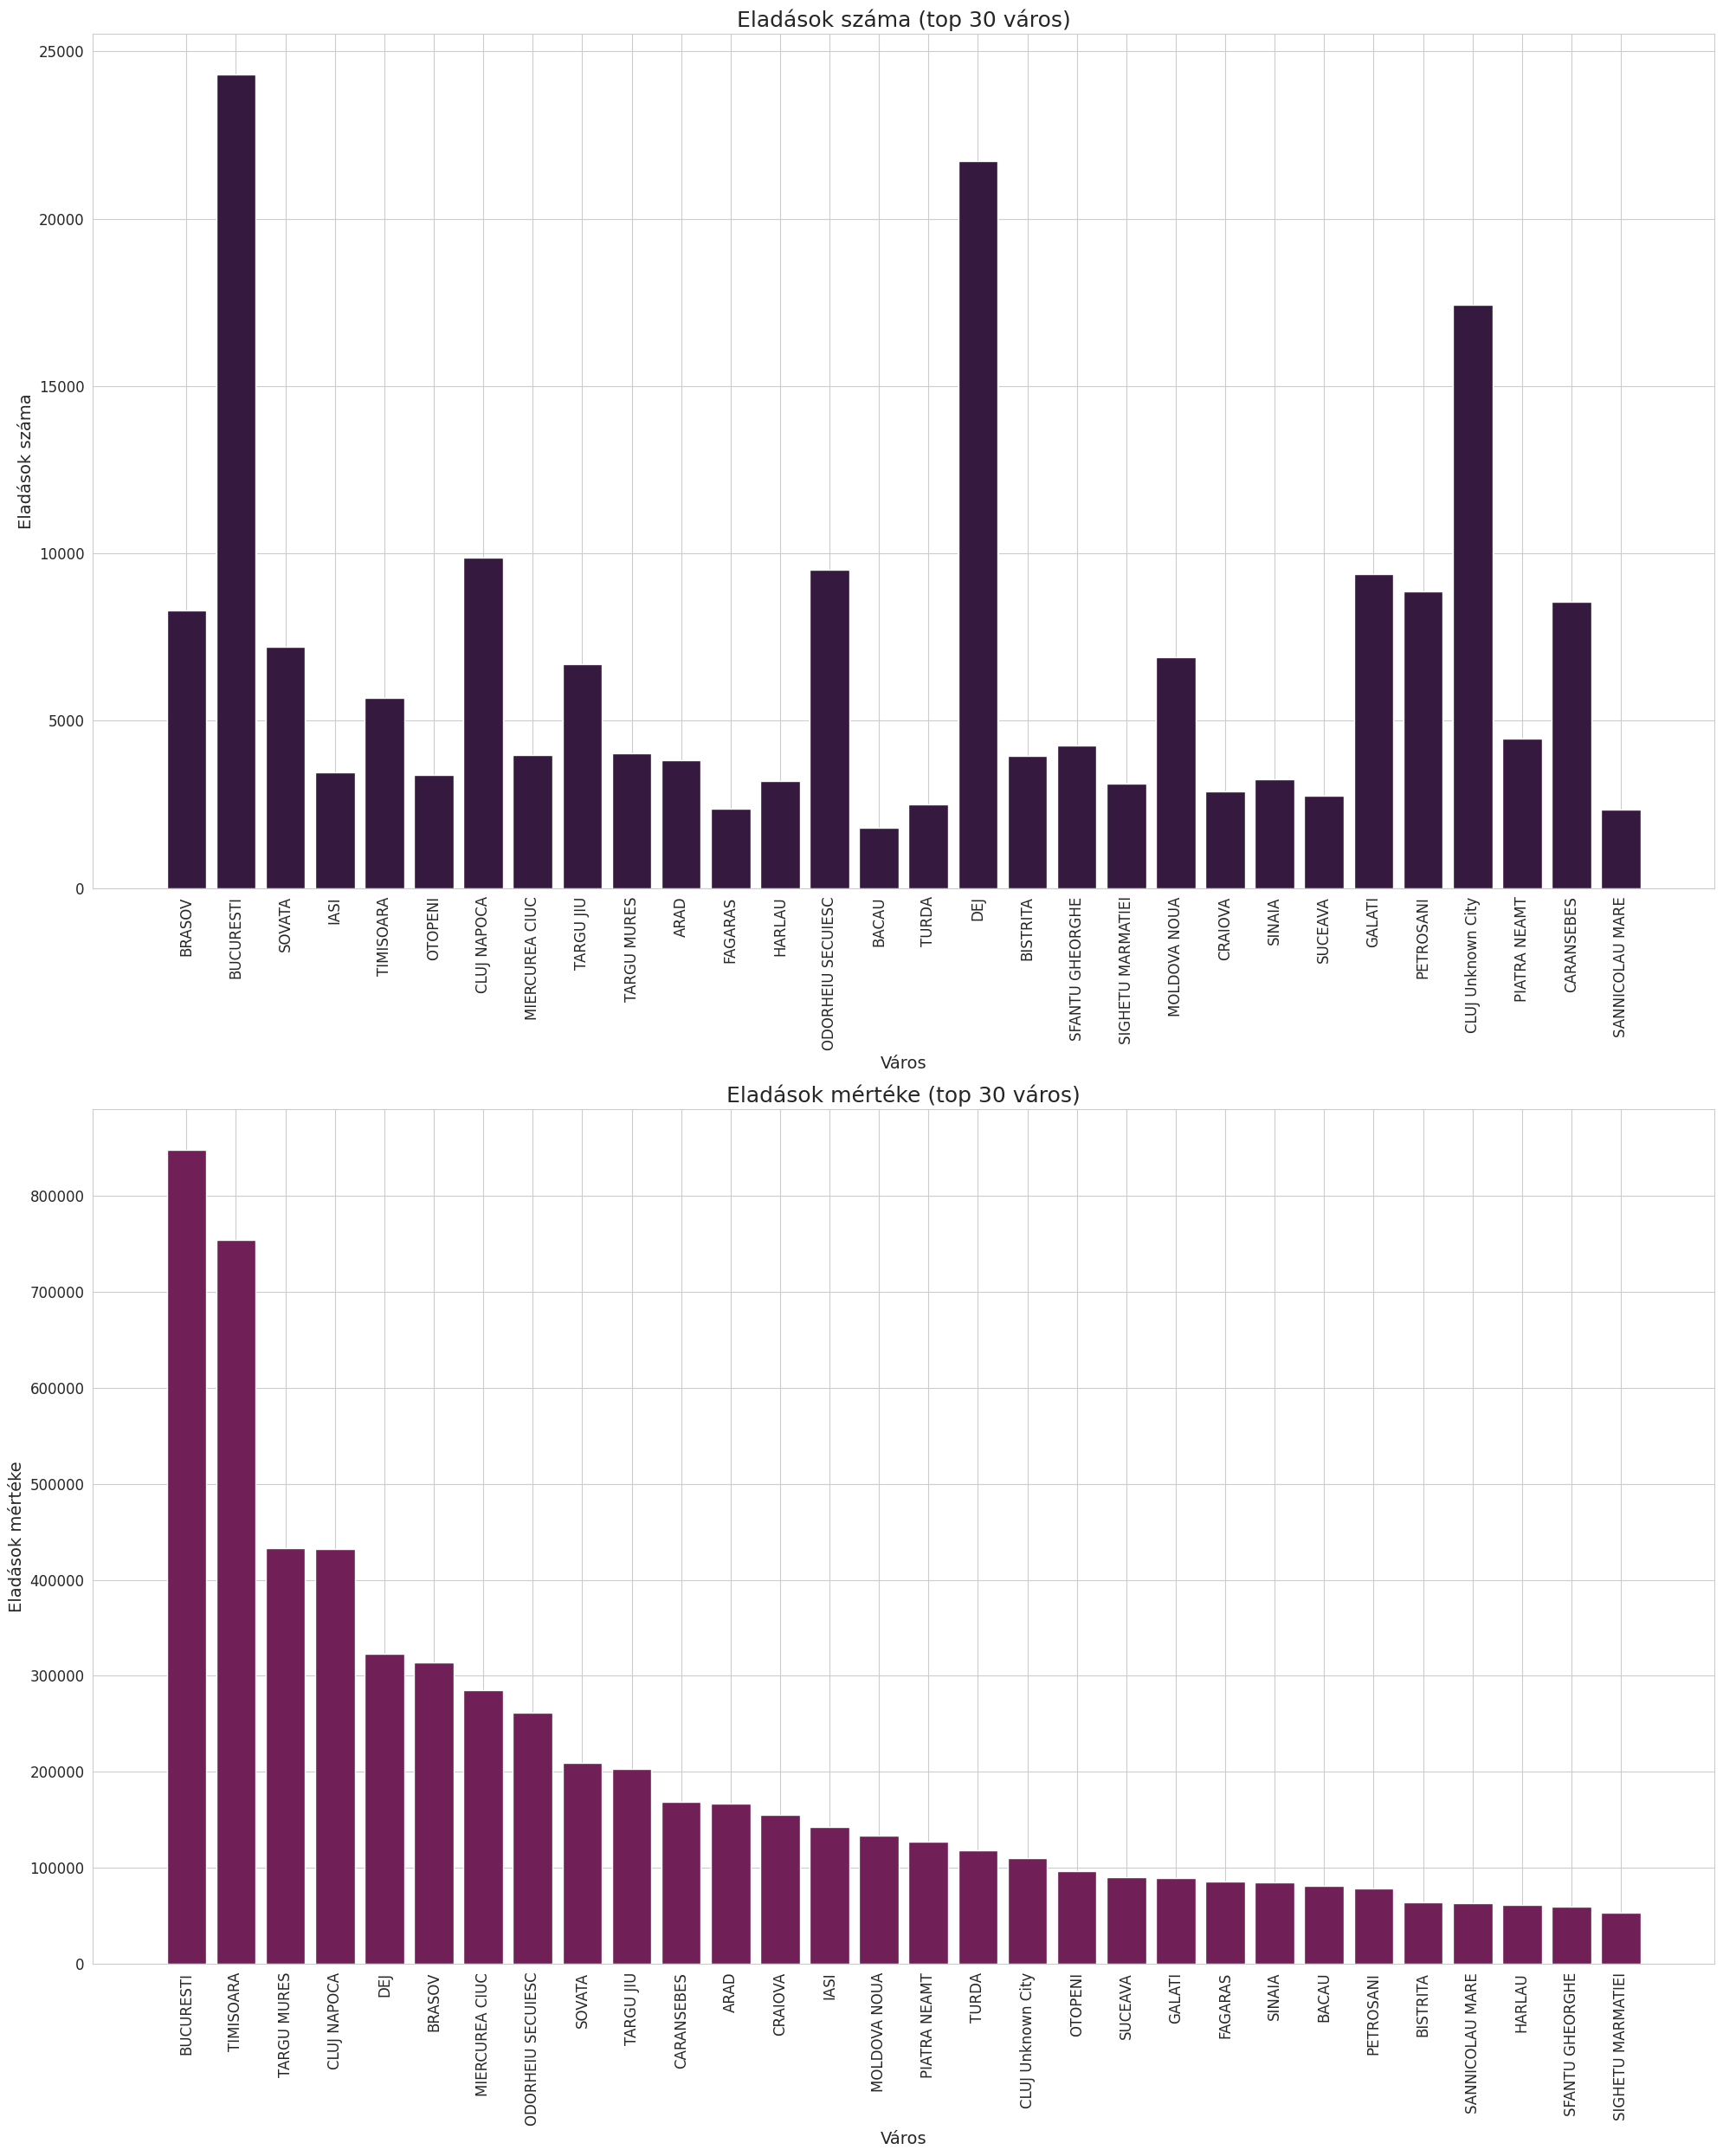

In [ ]:
city_sales_sum_filtered = filtered_data.groupby('City')['Sales'].sum().reset_index()
city_sales_sum_filtered.columns = ['City', 'Sales Sum']

top_30_cities = city_sales_sum_filtered.sort_values(by='Sales Sum', ascending=False).head(30)

fig, axs = plt.subplots(2, 1, figsize=(20, 25))

top_30_sales_data = data[data['City'].isin(top_30_cities['City'])]
axs[0].bar(top_30_sales_data['City'], top_30_sales_data['Sales'], color=palette[0], width=0.8)
axs[0].set_title('Eladások száma (top 30 város)', fontsize=18)
axs[0].set_xlabel('Város', fontsize=14)
axs[0].set_ylabel('Eladások száma', fontsize=14)
axs[0].tick_params(axis='x', rotation=90, labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

axs[1].bar(top_30_cities['City'], top_30_cities['Sales Sum'], color=palette[1], width=0.8)
axs[1].set_title('Eladások mértéke (top 30 város)', fontsize=18)
axs[1].set_xlabel('Város', fontsize=14)
axs[1].set_ylabel('Eladások mértéke', fontsize=14)
axs[1].tick_params(axis='x', rotation=90, labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

Következhet néhány fontosabb statisztika a fenti ábrához kapcsolódóan.

**Legtöbbször vásárló ügyfél**

In [ ]:
most_frequent_partner_count = data['PartnerId'].value_counts().max()
most_frequent_partner = data['PartnerId'].value_counts().idxmax()
city_of_most_frequent_partner = data[data['PartnerId'] == most_frequent_partner]['City'].iloc[0]

print("A legtöbbször vásárló ügyfél azonosítója:", most_frequent_partner)
print("Ehhez az ügyfélhez tartozó város:", city_of_most_frequent_partner)
print("Vásárlások száma:", most_frequent_partner_count)

A legtöbbször vásárló ügyfél azonosítója: 1098
Ehhez az ügyfélhez tartozó város: BUCURESTI
Vásárlások száma: 396


**Legnagyobb mértékben vásárló ügyfél**

In [ ]:
partner_with_highest_sales = data.groupby('PartnerId')['Sales'].sum().idxmax()
sales_of_highest_sales_partner = data.groupby('PartnerId')['Sales'].sum().max()
city_of_highest_sales_partner = data[data['PartnerId'] == partner_with_highest_sales]['City'].iloc[0]

print("A legnagyobb mértékben vásárló ügyfél:", partner_with_highest_sales)
print("Ehhez az ügyfélhez tartozó város:", city_of_highest_sales_partner)
print("Vásárolt érték:", sales_of_highest_sales_partner)

A legnagyobb mértékben vásárló ügyfél: 8191
Ehhez az ügyfélhez tartozó város: TARGU MURES
Vásárolt érték: 328839.63


**Legnagyobb értékesítési érték**

In [ ]:
max_positive_sales = data['Sales'].max()
max_positive_sales_data = data[data['Sales'] == max_positive_sales][['DocumentId', 'PartnerId', 'City']]

print("Legnagyobb értékesítési érték:", max_positive_sales)
print("\nAz ehhez tartozó adatok:")
print(max_positive_sales_data)


Legnagyobb értékesítési érték: 24313.420000000002

Az ehhez tartozó adatok:
      DocumentId  PartnerId       City
9817      823019       8191  BUCURESTI


**Legkisebb értékesítési érték**

In [ ]:
min_positive_sales = data['Sales'].min()
min_positive_sales_data = data[data['Sales'] == min_positive_sales][['DocumentId', 'PartnerId', 'City']]

print("Legkisebb pozitív értékesítési érték:", min_positive_sales)
print("\nAz ehhez tartozó adatok:")
print(min_positive_sales_data)

Legkisebb pozitív értékesítési érték: 6.42

Az ehhez tartozó adatok:
     DocumentId  PartnerId    City
343      779058      10592  BRASOV


Következhetnek további diagramok.

**Ügyfelek havi vásárlási tendenciái**



In [ ]:
data2 = data.copy()

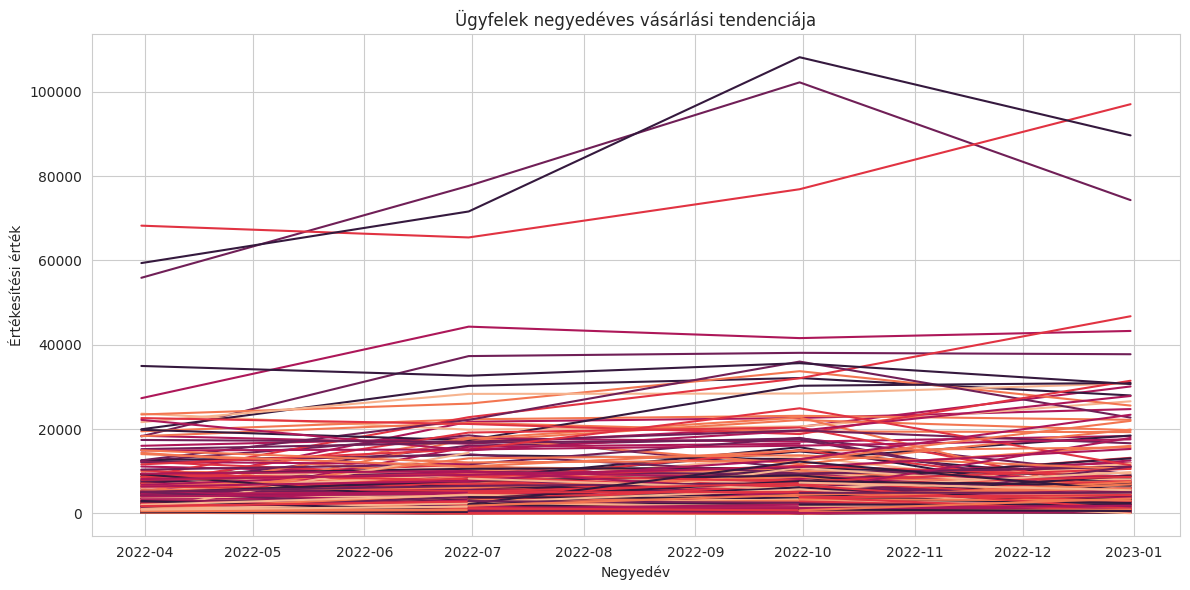

In [ ]:
average_sales = data2['Sales'].mean()

data2['DocumentDate'] = pd.to_datetime(data2['DocumentDate'])
data2.set_index('DocumentDate', inplace=True)
quarterly_sales = data2.resample('Q')['Sales'].sum()

trending_customers = data2.groupby('PartnerId')['Sales'].sum()
trending_customers = trending_customers[trending_customers > average_sales]

plt.figure(figsize=(12, 6))
for partner_id in trending_customers.index:
    partner_sales = data2[data2['PartnerId'] == partner_id]['Sales'].resample('Q').sum()
    plt.plot(partner_sales.index, partner_sales.values)

plt.title('Ügyfelek negyedéves vásárlási tendenciája')
plt.xlabel('Negyedév')
plt.ylabel('Értékesítési érték')
plt.grid(True)
plt.tight_layout()
plt.show()


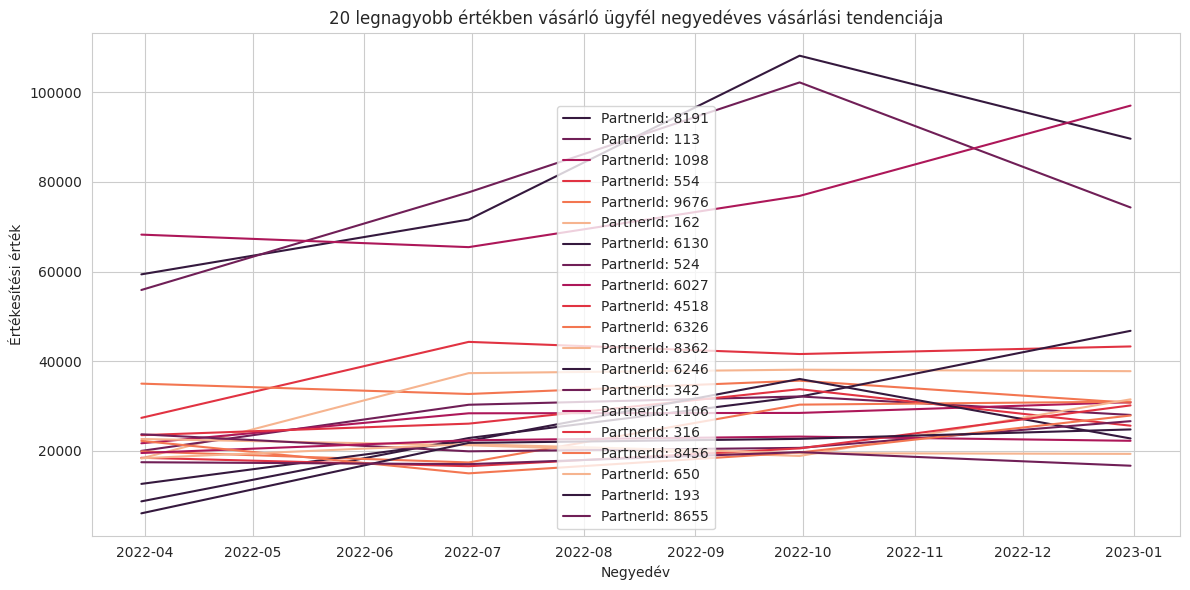

In [ ]:
top_20_customers = trending_customers.nlargest(20)

plt.figure(figsize=(12, 6))
for partner_id in top_20_customers.index:
    partner_sales = data2[data2['PartnerId'] == partner_id]['Sales'].resample('Q').sum()
    plt.plot(partner_sales.index, partner_sales.values, label=f'PartnerId: {partner_id}')

plt.title('20 legnagyobb értékben vásárló ügyfél negyedéves vásárlási tendenciája')
plt.xlabel('Negyedév')
plt.ylabel('Értékesítési érték')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

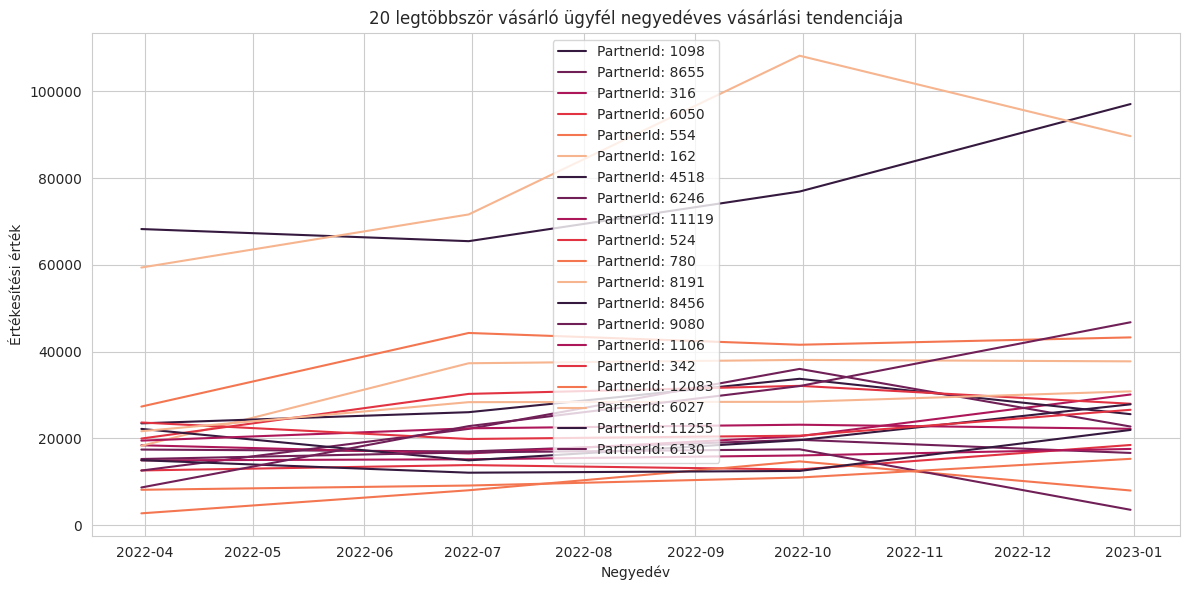

In [ ]:
partner_sales_count = data2.groupby('PartnerId').size()
top_20_customers = partner_sales_count.nlargest(20)

plt.figure(figsize=(12, 6))
for partner_id in top_20_customers.index:
    partner_sales = data2[data2['PartnerId'] == partner_id]['Sales'].resample('Q').sum()
    plt.plot(partner_sales.index, partner_sales.values, label=f'PartnerId: {partner_id}')

plt.title('20 legtöbbször vásárló ügyfél negyedéves vásárlási tendenciája')
plt.xlabel('Negyedév')
plt.ylabel('Értékesítési érték')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Statisztikák az eladásokról:

In [ ]:
sales_std = data['Sales'].std()
sales_var = data['Sales'].var()

sales_median = data['Sales'].median()
sales_quartiles = np.percentile(data['Sales'], [25, 50, 75])

print("Eladások szórása:", sales_std)
print("Eladások szórásnégyzete:", sales_var)
print("Eladások mediánja:", sales_median)
print("Eladások alsó kvartilise (Q1):", sales_quartiles[0])
print("Eladások mediánja (Q2):", sales_quartiles[1])
print("Eladások felső kvartilise (Q3):", sales_quartiles[2])

Eladások szórása: 1198.6518553069932
Eladások szórásnégyzete: 1436766.270230897
Eladások mediánja: 612.48
Eladások alsó kvartilise (Q1): 295.975
Eladások mediánja (Q2): 612.48
Eladások felső kvartilise (Q3): 1044.9499999999998


## **Kiugró értékek (outlierek) kezelése**

Következő nagyon fontos lépése az elemzésnek az outlierekek kezelése, amelyek bizonyos esetekben torzíthatják a modell teljesítményét.

Az outlierek ábrázolására a legjobb a dobozdiagram.

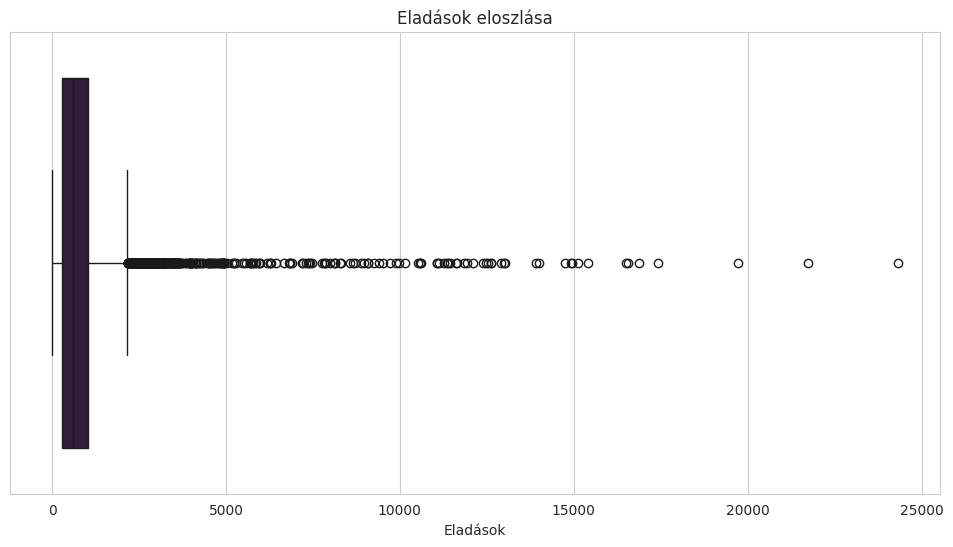

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['Sales'])
plt.title('Eladások eloszlása')
plt.xlabel('Eladások')
plt.show()

Statisztikai módszerekkel is megnézhetjük őket, használjuk jelenesetben az IQR módszert.

In [ ]:
Q1 = data['Sales'].quantile(0.25)
Q3 = data['Sales'].quantile(0.75)
IQR = Q3 - Q1

outliers = data[(data['Sales'] < (Q1 - 1.5 * IQR)) | (data['Sales'] > (Q3 + 1.5 * IQR))]

print(f'Outlierek száma: {outliers.shape[0]}')

Outlierek száma: 562


Elég sok kiugró érték azonosítható, viszont az elemzés szempontjából fontosak, nem hibás adatokként foghatók fel. Hozzájárulhatnak a csoportalkotáshoz mint fontos csoportjellemző.

## **FRM elemzés**

Az FRM analízis megvalósításához szükséges, hogy kiszámoljuk minden egyes partner esetén a gyakoriságot (hogy hány tranzakció köthető összesen hozzájuk), a frissességet (legutóbbi számla dátuma), illetve a pénzügyi értéket (összesen milyen értékben vásároltak a vállalattól).

**Frissesség számítás**

In [ ]:
data_recency = data.groupby(by='PartnerId',
                        as_index=False)['DocumentDate'].max()
data_recency.columns = ['PartnerId', 'LastPurchaseDate']
recent_date = data_recency['LastPurchaseDate'].max()
data_recency['Recency'] = data_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
data_recency.head()

PartnerId LastPurchaseDate  Recency
0          4       2022-12-14       16
1        113       2022-12-20       10
2        124       2022-11-07       53
3        125       2022-03-21      284
4        142       2022-10-17       74

Létrehoztunk egy olyan külön táblát, amiben a PartnerId mellé csatoltuk a legfrissebb vásárlásának dátumát, illetve, hogy az adott vásárlástól a cég legfrissebb tranzakciójáig hány nap telt el.

**Gyakoriság számítása**

In [ ]:
frequency_data = data.drop_duplicates().groupby(
    by=['PartnerId'], as_index=False)['DocumentDate'].count()
frequency_data.columns = ['PartnerId', 'Frequency']
frequency_data.head()

PartnerId  Frequency
0          4          2
1        113         45
2        124          7
3        125          1
4        142          3

Itt partnerenként kiszámoltuk, hogy hány tranzakció köthető összesen a nevükhöz.

**Pénzügyi érték számítás**

In [ ]:
monetary_data = data.groupby(by='PartnerId', as_index=False)['Sales'].sum()
monetary_data.columns = ['PartnerId', 'Monetary']
monetary_data.head()

PartnerId   Monetary
0          4    1404.80
1        113  310114.50
2        124    2106.01
3        125     445.00
4        142    1193.42

Ehhez a táblához partnerenként szummázzuk az eladott értékeket.

**Összesítés**

In [ ]:
rf_data = data_recency.merge(frequency_data, on='PartnerId')
rfm_data = rf_data.merge(monetary_data, on='PartnerId').drop(
    columns='LastPurchaseDate')
rfm_data.head()

PartnerId  Recency  Frequency   Monetary
0          4       16          2    1404.80
1        113       10         45  310114.50
2        124       53          7    2106.01
3        125      284          1     445.00
4        142       74          3    1193.42

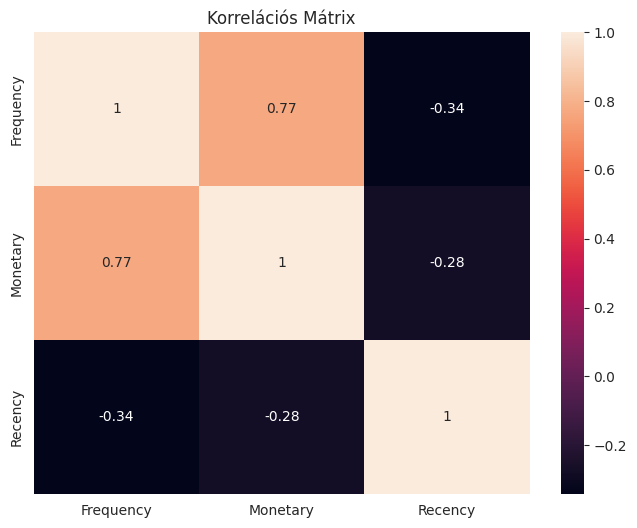

In [ ]:
numerical_cols = ['Frequency', 'Monetary', 'Recency']
correlation_matrix = rfm_data[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap=c_palette)

plt.title('Korrelációs Mátrix')
plt.show()

Ez a korrelációs mátrix a következőket mutatja meg:

* A legerősebb korreláció a gyakoriság és a pénzügyi érték között áll fent, és mivel pozitív a korreláció, ha az egyik érték nő, a másik is nagy eséllyel ugyanúgy nő
* A frissesség és a gyakoriság illetve a frissesség és pénzügyi érték között egy gyengébb negatív korreláció áll fent, ha az egyik nő, akkor a másik értéke csökkenthet

Nem ok-okozati kapcsolatot tükröz a jellemzők között.

A következő kódrészlet segíségével rangsoroljuk mindhárom jellemző alapján a klienseket, majd ezeknek a helyezés értékeknek kiszámoljuk egy skálázott, normalizált változatát.

In [ ]:
rfm_data['R_rank'] = rfm_data['Recency'].rank(ascending=False)
rfm_data['F_rank'] = rfm_data['Frequency'].rank(ascending=True)
rfm_data['M_rank'] = rfm_data['Monetary'].rank(ascending=True)

rfm_data['R_rank_norm'] = (rfm_data['R_rank']/rfm_data['R_rank'].max())*100
rfm_data['F_rank_norm'] = (rfm_data['F_rank']/rfm_data['F_rank'].max())*100
rfm_data['M_rank_norm'] = (rfm_data['F_rank']/rfm_data['M_rank'].max())*100

rfm_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_data.head()

PartnerId  Recency  Frequency   Monetary  R_rank_norm  F_rank_norm  \
0          4       16          2    1404.80    75.436409    29.900744   
1        113       10         45  310114.50    83.977556    95.471464   
2        124       53          7    2106.01    49.563591    59.429280   
3        125      284          1     445.00     9.538653    11.910670   
4        142       74          3    1193.42    44.139651    39.267990   

   M_rank_norm  
0    29.900744  
1    95.471464  
2    59.429280  
3    11.910670  
4    39.267990

**FRM érték számítása**

Az FRM értéket a frissesség, a gyakoriság, a pénzérték normalizált értéke alapján számítjuk ki. Ezen pontszám alapján osztjuk fel ügyfeleinket. Itt egy 5-ös skálán értékeljük őket.

Az FRM érték kiszámításához használt képlet: 0,15 \* Recency pontszám + 0,28 \* Frequency pontszám + 0,57 \* Monetáris pontszám

In [ ]:
rfm_data['RFM_Score'] = 0.15 * rfm_data['R_rank_norm'] + 0.28 * rfm_data['F_rank_norm'] + 0.57 * rfm_data['M_rank_norm']
rfm_data['RFM_Score'] = rfm_data['RFM_Score'] * 0.05
rfm_data = rfm_data.round(2)
rfm_data[['PartnerId', 'RFM_Score']].head()

PartnerId  RFM_Score
0          4       1.84
1        113       4.69
2        124       2.90
3        125       0.58
4        142       2.00

* FRM érték > 4.5: Legjobb kliensek

* 4.5 > FRM érték > 4: Értékes kliensek

* 4 > FRM érték > 3: Semleges kliensek

* 3 > FRM érték > 1.6: Kevésbé fontos kliensek

* 1.6 > FRM érték: Elveszített kliensek

In [ ]:
rfm_data["Customer_segment"] = np.where(rfm_data['RFM_Score'] >
                                      4.5, "Legjobb kliensek",
                                      (np.where(
                                        rfm_data['RFM_Score'] > 4,
                                        "Értékes kliensek",
                                        (np.where(
    rfm_data['RFM_Score'] > 3,
                             "Semleges kliensek",
                             np.where(rfm_data['RFM_Score'] > 1.6,
                            'Kevésbé fontos kliensek', 'Elveszített kliensek'))))))
rfm_data[['PartnerId', 'RFM_Score', 'Customer_segment']].head()

PartnerId  RFM_Score         Customer_segment
0          4       1.84  Kevésbé fontos kliensek
1        113       4.69         Legjobb kliensek
2        124       2.90  Kevésbé fontos kliensek
3        125       0.58     Elveszített kliensek
4        142       2.00  Kevésbé fontos kliensek

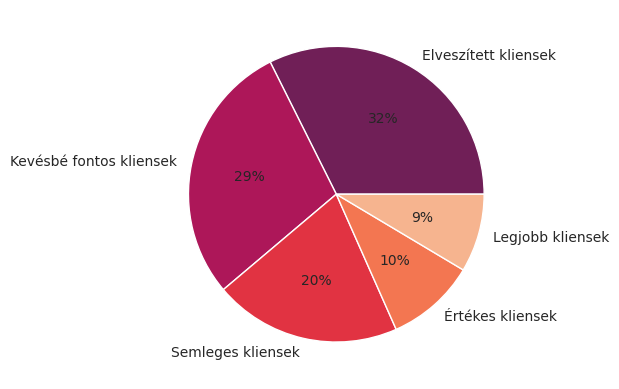

In [ ]:
plt.pie(rfm_data.Customer_segment.value_counts(),
        labels=rfm_data.Customer_segment.value_counts().index,
        autopct='%.0f%%',
        colors=palette[1:6])
plt.show()

Amint láthatjuk, a score alapján elég sok érdeklődést veszített klienst azonosítottunk.

In [ ]:
label = data[['PartnerId', 'City']]
label = pd.merge(label, rfm_data, on = 'PartnerId')

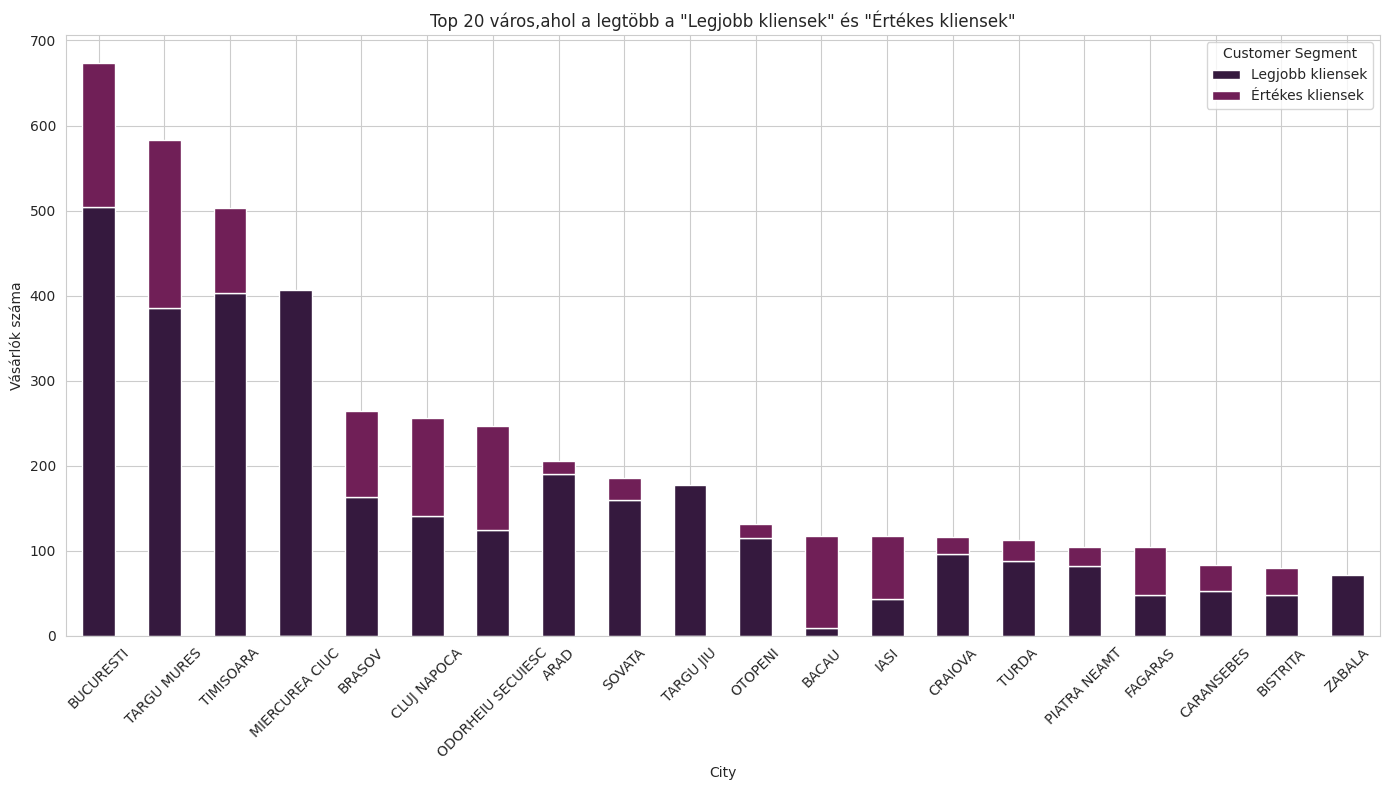

In [ ]:
filtered_data = label[label['Customer_segment'].isin(['Legjobb kliensek', 'Értékes kliensek'])]
city_segment_counts = filtered_data.groupby(['City', 'Customer_segment']).size().unstack().fillna(0)
top_cities = city_segment_counts.sum(axis=1).sort_values(ascending=False).head(20).index
top_city_segment_counts = city_segment_counts.loc[top_cities]
top_city_segment_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Top 20 város,ahol a legtöbb a "Legjobb kliensek" és "Értékes kliensek"')
plt.xlabel('City')
plt.ylabel('Vásárlók száma')
plt.legend(title='Customer Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

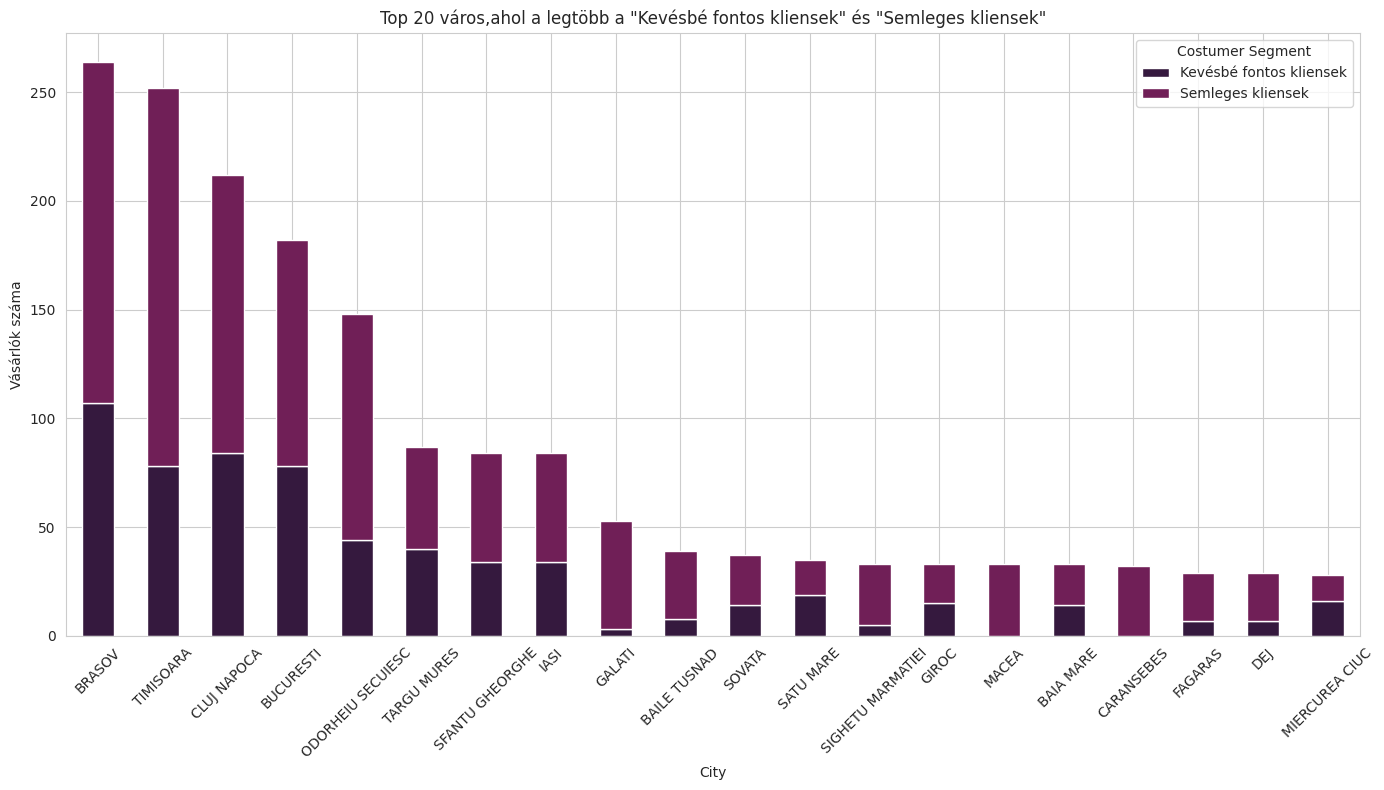

In [ ]:
filtered_data = label[label['Customer_segment'].isin(['Kevésbé fontos kliensek', 'Semleges kliensek'])]
city_segment_counts = filtered_data.groupby(['City', 'Customer_segment']).size().unstack().fillna(0)
top_cities = city_segment_counts.sum(axis=1).sort_values(ascending=False).head(20).index
top_city_segment_counts = city_segment_counts.loc[top_cities]
top_city_segment_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Top 20 város,ahol a legtöbb a "Kevésbé fontos kliensek" és "Semleges kliensek"')
plt.xlabel('City')
plt.ylabel('Vásárlók száma')
plt.legend(title='Costumer Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Következő fázis az adatdimenziók modellezhető formára hozása.

## **Feature Engineering**

**Rfm_data átalakítása**

In [ ]:
rfm_data.head()

PartnerId  Recency  Frequency   Monetary  R_rank_norm  F_rank_norm  \
0          4       16          2    1404.80        75.44        29.90   
1        113       10         45  310114.50        83.98        95.47   
2        124       53          7    2106.01        49.56        59.43   
3        125      284          1     445.00         9.54        11.91   
4        142       74          3    1193.42        44.14        39.27   

   M_rank_norm  RFM_Score         Customer_segment  
0        29.90       1.84  Kevésbé fontos kliensek  
1        95.47       4.69         Legjobb kliensek  
2        59.43       2.90  Kevésbé fontos kliensek  
3        11.91       0.58     Elveszített kliensek  
4        39.27       2.00  Kevésbé fontos kliensek

Indítunk egy labels nevű adatkeretet is, amibe olyan változókat szedünk össze, amelyeket majd interaktívan meg akarunk jeleníteni a klasztervizualizációkon.

In [ ]:
labels = rfm_data[['PartnerId', 'RFM_Score', 'Customer_segment']]
labels.head()

PartnerId  RFM_Score         Customer_segment
0          4       1.84  Kevésbé fontos kliensek
1        113       4.69         Legjobb kliensek
2        124       2.90  Kevésbé fontos kliensek
3        125       0.58     Elveszített kliensek
4        142       2.00  Kevésbé fontos kliensek

In [ ]:
rfm_data.dtypes

PartnerId             int64
Recency               int64
Frequency             int64
Monetary            float64
R_rank_norm         float64
F_rank_norm         float64
M_rank_norm         float64
RFM_Score           float64
Customer_segment     object
dtype: object

Itt minden érték numerikus, csak az ügyfélbesorolás oszlopot kell átalakítanunk dummy változók segítségével.

***Customer_segment***

In [ ]:
encoded_data = pd.get_dummies(rfm_data['Customer_segment'])
rfm_data = pd.concat([rfm_data, encoded_data], axis=1)
rfm_data.drop('Customer_segment', axis=1, inplace=True)
rfm_data.head()

PartnerId  Recency  Frequency   Monetary  R_rank_norm  F_rank_norm  \
0          4       16          2    1404.80        75.44        29.90   
1        113       10         45  310114.50        83.98        95.47   
2        124       53          7    2106.01        49.56        59.43   
3        125      284          1     445.00         9.54        11.91   
4        142       74          3    1193.42        44.14        39.27   

   M_rank_norm  RFM_Score  Elveszített kliensek  Kevésbé fontos kliensek  \
0        29.90       1.84                 False                     True   
1        95.47       4.69                 False                    False   
2        59.43       2.90                 False                     True   
3        11.91       0.58                  True                    False   
4        39.27       2.00                 False                     True   

   Legjobb kliensek  Semleges kliensek  Értékes kliensek  
0             False              False             False  
1              True              False             False  
2             False              False             False  
3             False              False             False  
4             False              False             False

In [ ]:
rfm_data.dtypes

PartnerId                    int64
Recency                      int64
Frequency                    int64
Monetary                   float64
R_rank_norm                float64
F_rank_norm                float64
M_rank_norm                float64
RFM_Score                  float64
Elveszített kliensek          bool
Kevésbé fontos kliensek       bool
Legjobb kliensek              bool
Semleges kliensek             bool
Értékes kliensek              bool
dtype: object

In [ ]:
rfm_data.shape

(806, 13)

**Data átalakítása**

In [ ]:
data.head()

DocumentId  PartnerId DocumentDate       City  Sales Quarter
343      779058      10592   2022-04-13     BRASOV   6.42  2022Q2
344      829740      12054   2022-10-27      GIROC   6.83  2022Q4
345      829748      12593   2022-10-27    CORUNCA   6.83  2022Q4
346      781716      11567   2022-04-26  BUCURESTI  10.90  2022Q2
347      803442        162   2022-07-14     SOVATA  11.76  2022Q3

A két táblát kell összekapcsolnunk, ahhoz viszont egyszer a data adatkeretben PartnerId szerint kell csoportosítanunk a többi jellemzőt, és ezen dimenziókat is numerikussá alakítani.

***DocumentId***

A DocumentId oszlopot eltávolíthatjuk.

In [ ]:
data = data[['PartnerId', 'DocumentDate', 'City', 'Sales', 'Quarter']]
data.head()

PartnerId DocumentDate       City  Sales Quarter
343      10592   2022-04-13     BRASOV   6.42  2022Q2
344      12054   2022-10-27      GIROC   6.83  2022Q4
345      12593   2022-10-27    CORUNCA   6.83  2022Q4
346      11567   2022-04-26  BUCURESTI  10.90  2022Q2
347        162   2022-07-14     SOVATA  11.76  2022Q3

A különböző oszlopok esetén különböző aggregálási módszereket fogunk tudni használni, így külön dolgozunk velük és majd összesítjük.

***City***

A városoknál vesszük az egyik (első) értéket:

In [ ]:
cities = data[['PartnerId', 'City']]
cities = cities.groupby('PartnerId')['City'].first().reset_index()
cities.head()

PartnerId        City
0          4      BRASOV
1        113         DEJ
2        124      BRASOV
3        125      BRASOV
4        142  SIGHISOARA

In [ ]:
labels = pd.merge(labels, cities, on='PartnerId')
labels.head()

PartnerId  RFM_Score         Customer_segment        City
0          4       1.84  Kevésbé fontos kliensek      BRASOV
1        113       4.69         Legjobb kliensek         DEJ
2        124       2.90  Kevésbé fontos kliensek      BRASOV
3        125       0.58     Elveszített kliensek      BRASOV
4        142       2.00  Kevésbé fontos kliensek  SIGHISOARA

A városokat ugyancsak dummy változók segíségével tudjuk átalakítani.

In [ ]:
encoded_data = pd.get_dummies(cities['City'])
cities = pd.concat([cities, encoded_data], axis=1)
cities.drop('City', axis=1, inplace=True)
cities.head()

PartnerId   ADEA  AGHIRESU FABRICI   AIUD  ALBA IULIA  ALBESTI  AMARA  \
0          4  False             False  False       False    False  False   
1        113  False             False  False       False    False  False   
2        124  False             False  False       False    False  False   
3        125  False             False  False       False    False  False   
4        142  False             False  False       False    False  False   

   ANDRID   ARAD  ARMENIS  ...  VLADIMIRESCU  VLAHA  VOLUNTARI  VULCAN  \
0   False  False    False  ...         False  False      False   False   
1   False  False    False  ...         False  False      False   False   
2   False  False    False  ...         False  False      False   False   
3   False  False    False  ...         False  False      False   False   
4   False  False    False  ...         False  False      False   False   

   ZABALA  ZALAU    ZAM  ZARNESTI  ZETEA  ZOLTAN  
0   False  False  False     False  False   False  
1   False  False  False     False  False   False  
2   False  False  False     False  False   False  
3   False  False  False     False  False   False  
4   False  False  False     False  False   False  

[5 rows x 232 columns]

In [ ]:
cities.dtypes

PartnerId           int64
ADEA                 bool
AGHIRESU FABRICI     bool
AIUD                 bool
ALBA IULIA           bool
                    ...  
ZALAU                bool
ZAM                  bool
ZARNESTI             bool
ZETEA                bool
ZOLTAN               bool
Length: 232, dtype: object

In [ ]:
cities.shape

(806, 232)

***DocumentDate***

A dokumentum dátumoknál készítünk 3 új változót: az ügyfél első vásárlásának dátuma, az utolsó vásárlás dátuma és a két dátum között eltelt napok száma.

In [ ]:
docs = data[['PartnerId', 'DocumentDate']]
docs = docs.groupby('PartnerId').agg(
    EarliestDocument=('DocumentDate', 'min'),
    LatestDocument=('DocumentDate', 'max'),
).reset_index()
docs['DaysBetween'] = (docs['LatestDocument'] - docs['EarliestDocument']).dt.days
docs.head()

PartnerId EarliestDocument LatestDocument  DaysBetween
0          4       2022-08-24     2022-12-14          112
1        113       2022-01-06     2022-12-20          348
2        124       2022-01-14     2022-11-07          297
3        125       2022-03-21     2022-03-21            0
4        142       2022-04-26     2022-10-17          174

In [ ]:
labels = pd.merge(labels, docs, on='PartnerId')
labels.head()

PartnerId  RFM_Score         Customer_segment        City EarliestDocument  \
0          4       1.84  Kevésbé fontos kliensek      BRASOV       2022-08-24   
1        113       4.69         Legjobb kliensek         DEJ       2022-01-06   
2        124       2.90  Kevésbé fontos kliensek      BRASOV       2022-01-14   
3        125       0.58     Elveszített kliensek      BRASOV       2022-03-21   
4        142       2.00  Kevésbé fontos kliensek  SIGHISOARA       2022-04-26   

  LatestDocument  DaysBetween  
0     2022-12-14          112  
1     2022-12-20          348  
2     2022-11-07          297  
3     2022-03-21            0  
4     2022-10-17          174

In [ ]:
docs.dtypes

PartnerId                    int64
EarliestDocument    datetime64[ns]
LatestDocument      datetime64[ns]
DaysBetween                  int64
dtype: object

Itt is numerikussá kell alakítanunk, még pedig úgy hogy az adott dátumig hány nap telt el az adott évben.

In [ ]:
reference_date = pd.Timestamp('2022-01-01')
docs['EarliestDocument'] = (docs['EarliestDocument'] - reference_date).dt.days
docs['LatestDocument'] = (docs['LatestDocument'] - reference_date).dt.days
docs.head()

PartnerId  EarliestDocument  LatestDocument  DaysBetween
0          4               235             347          112
1        113                 5             353          348
2        124                13             310          297
3        125                79              79            0
4        142               115             289          174

In [ ]:
docs.dtypes

PartnerId           int64
EarliestDocument    int64
LatestDocument      int64
DaysBetween         int64
dtype: object

In [ ]:
docs.shape

(806, 4)

Következhetnek a további dimenziók.

***Sales***

A vásárlások értékénél készítünk 2 új változót: értékek átlaga és összege.

In [ ]:
sales = data[['PartnerId', 'Sales']]
sales = sales.groupby('PartnerId').agg(
    SalesMean=('Sales', 'mean'),
    SalesSum=('Sales', 'sum'),
).reset_index()
sales.head()

PartnerId    SalesMean   SalesSum
0          4   702.400000    1404.80
1        113  6891.433333  310114.50
2        124   300.858571    2106.01
3        125   445.000000     445.00
4        142   397.806667    1193.42

In [ ]:
labels = pd.merge(labels, sales, on='PartnerId')
labels.head()

PartnerId  RFM_Score         Customer_segment        City EarliestDocument  \
0          4       1.84  Kevésbé fontos kliensek      BRASOV       2022-08-24   
1        113       4.69         Legjobb kliensek         DEJ       2022-01-06   
2        124       2.90  Kevésbé fontos kliensek      BRASOV       2022-01-14   
3        125       0.58     Elveszített kliensek      BRASOV       2022-03-21   
4        142       2.00  Kevésbé fontos kliensek  SIGHISOARA       2022-04-26   

  LatestDocument  DaysBetween    SalesMean   SalesSum  
0     2022-12-14          112   702.400000    1404.80  
1     2022-12-20          348  6891.433333  310114.50  
2     2022-11-07          297   300.858571    2106.01  
3     2022-03-21            0   445.000000     445.00  
4     2022-10-17          174   397.806667    1193.42

In [ ]:
sales.dtypes

PartnerId      int64
SalesMean    float64
SalesSum     float64
dtype: object

In [ ]:
sales.shape

(806, 3)

***Quarter***

Azok közül, hogy az adott ügyfél milyen negyedévekben vásárolt, vesszük a leggyakoribb értéket.

In [ ]:
quarters = data[['PartnerId', 'Quarter']]
quarters = quarters.groupby('PartnerId')['Quarter'].agg(lambda x: x.mode()[0]).reset_index()
quarters.head()

PartnerId Quarter
0          4  2022Q3
1        113  2022Q2
2        124  2022Q1
3        125  2022Q1
4        142  2022Q2

In [ ]:
labels = pd.merge(labels, quarters, on='PartnerId')
labels.head()

PartnerId  RFM_Score         Customer_segment        City EarliestDocument  \
0          4       1.84  Kevésbé fontos kliensek      BRASOV       2022-08-24   
1        113       4.69         Legjobb kliensek         DEJ       2022-01-06   
2        124       2.90  Kevésbé fontos kliensek      BRASOV       2022-01-14   
3        125       0.58     Elveszített kliensek      BRASOV       2022-03-21   
4        142       2.00  Kevésbé fontos kliensek  SIGHISOARA       2022-04-26   

  LatestDocument  DaysBetween    SalesMean   SalesSum Quarter  
0     2022-12-14          112   702.400000    1404.80  2022Q3  
1     2022-12-20          348  6891.433333  310114.50  2022Q2  
2     2022-11-07          297   300.858571    2106.01  2022Q1  
3     2022-03-21            0   445.000000     445.00  2022Q1  
4     2022-10-17          174   397.806667    1193.42  2022Q2

In [ ]:
quarters.dtypes

PartnerId            int64
Quarter      period[Q-DEC]
dtype: object

In [ ]:
quarters['Quarter'] = quarters['Quarter'].dt.quarter
quarters.head()

PartnerId  Quarter
0          4        3
1        113        2
2        124        1
3        125        1
4        142        2

In [ ]:
quarters.dtypes

PartnerId    int64
Quarter      int64
dtype: object

In [ ]:
quarters.shape

(806, 2)

Most az a dolgunk hogy az összes táblát összekapcsoljuk egy nagy táblává.

In [ ]:
rfm_data.set_index('PartnerId', inplace=True)
docs.set_index('PartnerId', inplace=True)
cities.set_index('PartnerId', inplace=True)
sales.set_index('PartnerId', inplace=True)
quarters.set_index('PartnerId', inplace=True)

dfs = [rfm_data, docs, cities, sales, quarters]

merged_data = pd.concat(dfs, axis=1)
merged_data.reset_index(inplace=True)
merged_data.head()

PartnerId  Recency  Frequency   Monetary  R_rank_norm  F_rank_norm  \
0          4       16          2    1404.80        75.44        29.90   
1        113       10         45  310114.50        83.98        95.47   
2        124       53          7    2106.01        49.56        59.43   
3        125      284          1     445.00         9.54        11.91   
4        142       74          3    1193.42        44.14        39.27   

   M_rank_norm  RFM_Score  Elveszített kliensek  Kevésbé fontos kliensek  ...  \
0        29.90       1.84                 False                     True  ...   
1        95.47       4.69                 False                    False  ...   
2        59.43       2.90                 False                     True  ...   
3        11.91       0.58                  True                    False  ...   
4        39.27       2.00                 False                     True  ...   

   VULCAN  ZABALA  ZALAU    ZAM  ZARNESTI  ZETEA  ZOLTAN    SalesMean  \
0   False   False  False  False     False  False   False   702.400000   
1   False   False  False  False     False  False   False  6891.433333   
2   False   False  False  False     False  False   False   300.858571   
3   False   False  False  False     False  False   False   445.000000   
4   False   False  False  False     False  False   False   397.806667   

    SalesSum  Quarter  
0    1404.80        3  
1  310114.50        2  
2    2106.01        1  
3     445.00        1  
4    1193.42        2  

[5 rows x 250 columns]

In [ ]:
merged_data.shape

(806, 250)

Elkészült a modellezéshez szükséges adatkeret, 806 ügyfélsor, 250 jellemző.

## **Modellezés**

Többféle klaszterezési algoritmust kipróbálunk a modellezésre:
* K-Means klaszterezés
* Hierarhikus klaszterezés
* DBSCAN klaszterezés
* Spectral klaszterezés
* Gaussian Mixture Model

Kétféle módszer vizsgálunk, hogy eldönthessük az optimális klaszterszámot:

* Silhouette score
* Elbow method

Illetve kétféle dimenziócsökkentési algoritmusra is szükségünk lesz, hogy vizualizálni tudjuk az eredményeket, tudjuk két dimenzióra hozni az adatpontok elhelyezkedését a térben:

* t-SNE
* PCA

**Adatpontok ábrázolása kétdimenziós térben**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(merged_data)
data_pca = pca.transform(merged_data)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(merged_data)

<ipython-input-120-a71d089aafd5>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0].scatter(data_tsne[:, 0], data_tsne[:, 1], s=50, cmap=c_palette)
<ipython-input-120-a71d089aafd5>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(data_pca[:, 0], data_pca[:, 1], s=50, cmap=c_palette)


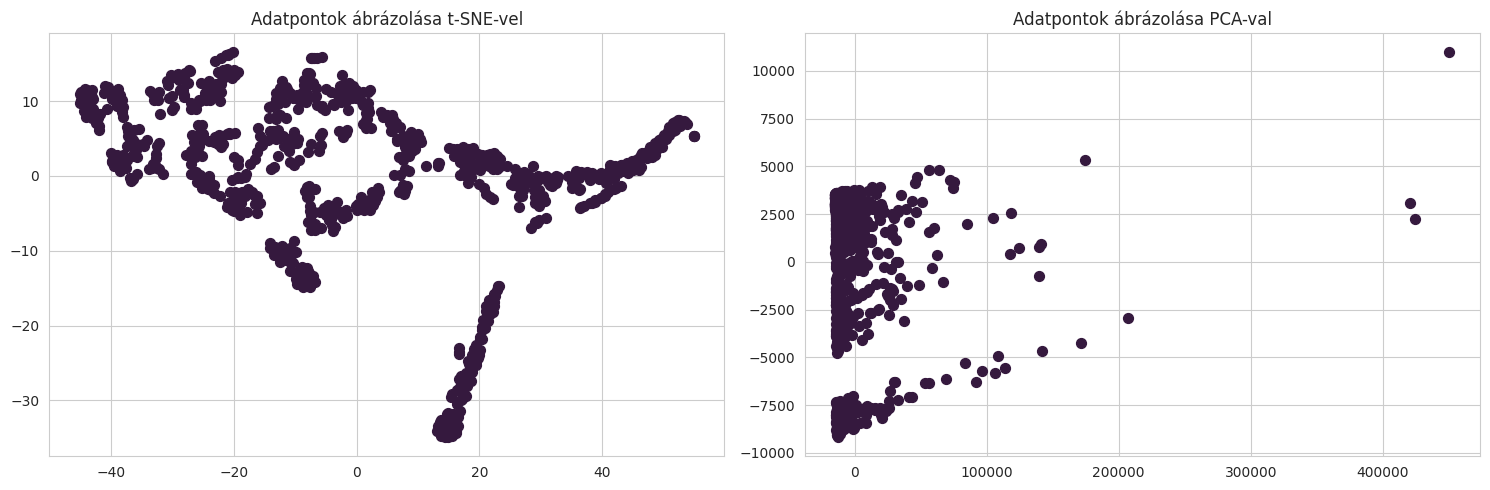

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].scatter(data_tsne[:, 0], data_tsne[:, 1], s=50, cmap=c_palette)
axes[0].set_title('Adatpontok ábrázolása t-SNE-vel')

axes[1].scatter(data_pca[:, 0], data_pca[:, 1], s=50, cmap=c_palette)
axes[1].set_title('Adatpontok ábrázolása PCA-val')

plt.tight_layout()
plt.show()

Majd meglátjuk a klaszterek kialakítása után, hogy melyiket lesz könnyebb leolvasni és átlátni.

### **K-Means klaszterezés**

Először meg kell találnunk az optimális klaszterszámot. Meghatározzuk, hogy legalább 3 ügyfélcsoport kellene legyen, de nem több mint 10, mert az nem kezelhető könnyen marketing stratégiák szempontjából, főleg, hogy a marketingosztályon csak 2 személy foglalkozik ezzel. Tehát 3-10 között választunk majd mindenképp klaszterszámot.

**Silhouette score**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

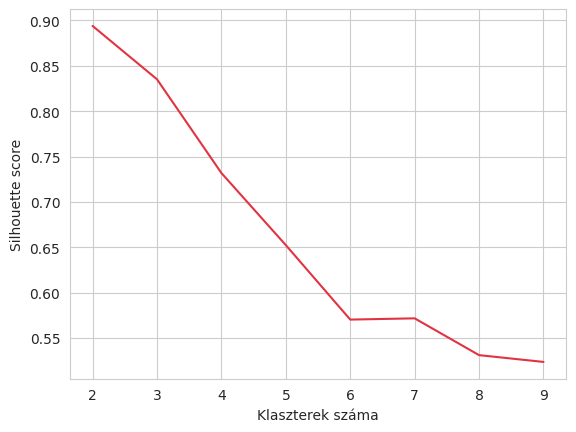

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouette_scores = []
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, init = 'k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(merged_data)
    silhouette_scores.append(silhouette_score(merged_data, cluster_labels))
plt.plot(range(2, 10), silhouette_scores, color=palette[3])
plt.xlabel('Klaszterek száma')
plt.ylabel('Silhouette score')
plt.show()

**Elbow method**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

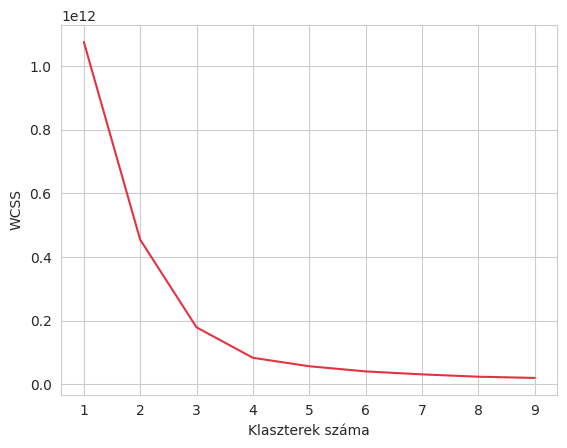

In [ ]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(merged_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss, color=palette[3])
plt.xlabel('Klaszterek száma')
plt.ylabel('WCSS')
plt.show()

A két ábra alapján megfigyelhetjük, hogy összességében a 4 klaszterre való osztással a vállalat a pontos ügyfélcsoportokat kapna.

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(merged_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Ábrázoljuk is a klasztereket a matplotlib könyvtár segítségével, vagy plotly vizualizációt is készítünk, hogy interaktívabbá tegyük.

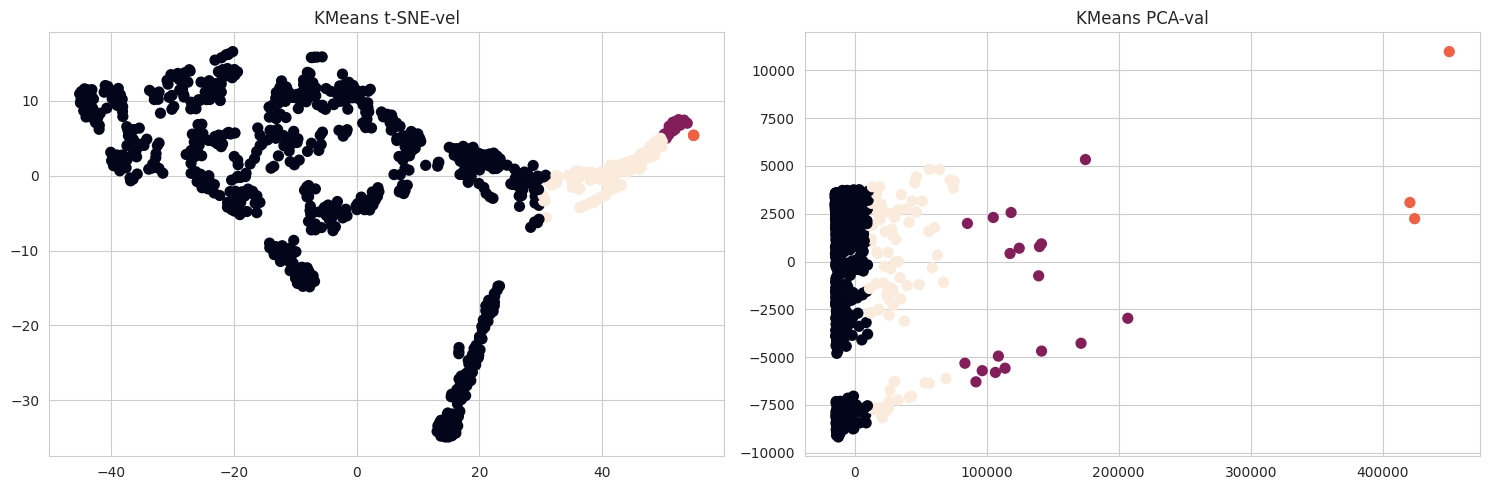

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].scatter(data_tsne[:, 0], data_tsne[:, 1], c=y_kmeans, s=50, cmap=c_palette)
axes[0].set_title('KMeans t-SNE-vel')

axes[1].scatter(data_pca[:, 0], data_pca[:, 1], c=y_kmeans, s=50, cmap=c_palette)
axes[1].set_title('KMeans PCA-val')

plt.tight_layout()
plt.show()

In [ ]:
hover_labels = labels.apply(lambda row: ', '.join([f'{col}: {val}' for col, val in row.items()]), axis=1).tolist()

In [ ]:
import plotly.express as px
from matplotlib.colors import rgb2hex

temp = pd.DataFrame({
    'tsne_1': data_tsne[:, 0],
    'tsne_2': data_tsne[:, 1],
    'cluster': y_kmeans,
    'hover_label': hover_labels
})

temp['cluster'] = temp['cluster'].astype(str)

hex_palette = [rgb2hex(color) for color in palette]

custom_cmap = {
    '0': hex_palette[1],
    '1': hex_palette[2],
    '2': hex_palette[3],
    '3': hex_palette[4]
}

In [ ]:
fig = px.scatter(
    temp,
    x='tsne_1',
    y='tsne_2',
    color='cluster',
    hover_name='hover_label',
    color_discrete_map=custom_cmap
)

fig.update_traces(hovertemplate='%{hovertext}')
fig.show()

In [ ]:
temp2 = pd.DataFrame({
    'pca_1': data_pca[:, 0],
    'pca_2': data_pca[:, 1],
    'cluster': y_kmeans,
    'hover_label': hover_labels
})

temp2['cluster'] = temp2['cluster'].astype(str)

hex_palette = [rgb2hex(color) for color in palette]

custom_cmap = {
    '0': hex_palette[1],
    '1': hex_palette[2],
    '2': hex_palette[3],
    '3': hex_palette[4]
}

In [ ]:
fig = px.scatter(
    temp2,
    x='pca_1',
    y='pca_2',
    color='cluster',
    hover_name='hover_label',
    color_discrete_map=custom_cmap
)

fig.update_traces(hovertemplate='%{hovertext}')
fig.show()

In [ ]:
y_kmeansd = pd.DataFrame(y_kmeans)
y_kmeansd.columns = ['Cluster']
groups = pd.concat([labels, y_kmeansd], axis=1)

Az alábbi tábla és az ábrák segítségével böngészhetjük a különböző  ügyfélcsoportok tagjait.

In [ ]:
groups[groups['Cluster'] == 0]

PartnerId  RFM_Score         Customer_segment          City  \
0            4       1.84  Kevésbé fontos kliensek        BRASOV   
2          124       2.90  Kevésbé fontos kliensek        BRASOV   
3          125       0.58     Elveszített kliensek        BRASOV   
4          142       2.00  Kevésbé fontos kliensek    SIGHISOARA   
5          143       3.97        Semleges kliensek        BRASOV   
..         ...        ...                      ...           ...   
801      12801       1.16     Elveszített kliensek  MOSNITA NOUA   
802      12802       1.16     Elveszített kliensek       BECLEAN   
803      12807       1.94  Kevésbé fontos kliensek  BAIA DE FIER   
804      12809       1.20     Elveszített kliensek   CLUJ NAPOCA   
805      12812       1.23     Elveszített kliensek       CRAIOVA   

    EarliestDocument LatestDocument  DaysBetween    SalesMean  SalesSum  \
0         2022-08-24     2022-12-14          112   702.400000   1404.80   
2         2022-01-14     2022-11-07          297   300.858571   2106.01   
3         2022-03-21     2022-03-21            0   445.000000    445.00   
4         2022-04-26     2022-10-17          174   397.806667   1193.42   
5         2022-01-04     2022-12-29          359   665.690714   9319.67   
..               ...            ...          ...          ...       ...   
801       2022-12-21     2022-12-21            0    76.010000     76.01   
802       2022-12-21     2022-12-21            0   810.510000    810.51   
803       2022-12-22     2022-12-22            0  1932.650000   3865.30   
804       2022-12-27     2022-12-27            0   323.530000    323.53   
805       2022-12-28     2022-12-28            0   131.820000    131.82   

    Quarter  Cluster  
0    2022Q3        0  
2    2022Q1        0  
3    2022Q1        0  
4    2022Q2        0  
5    2022Q3        0  
..      ...      ...  
801  2022Q4        0  
802  2022Q4        0  
803  2022Q4        0  
804  2022Q4        0  
805  2022Q4        0  

[694 rows x 11 columns]

In [ ]:
groups[groups['Cluster'] == 1]

PartnerId  RFM_Score  Customer_segment               City  \
9          162       4.92  Legjobb kliensek             SOVATA   
10         193       4.58  Legjobb kliensek          TIMISOARA   
17         316       4.96  Legjobb kliensek          TIMISOARA   
20         342       4.77  Legjobb kliensek     MIERCUREA CIUC   
37         524       4.90  Legjobb kliensek       PIATRA NEAMT   
40         554       4.98  Legjobb kliensek            CRAIOVA   
48         650       4.49  Értékes kliensek          PETROSANI   
93        1106       4.90  Legjobb kliensek            SUCEAVA   
112       1387       4.80  Legjobb kliensek        CLUJ NAPOCA   
133       4518       4.82  Legjobb kliensek          TARGU JIU   
180       6027       4.84  Legjobb kliensek          TIMISOARA   
184       6130       4.85  Legjobb kliensek  CLUJ Unknown City   
188       6246       4.88  Legjobb kliensek          TARGU JIU   
194       6326       4.52  Legjobb kliensek          TIMISOARA   
271       8362       4.83  Legjobb kliensek         CARANSEBES   
277       8456       4.89  Legjobb kliensek             SINAIA   
282       8655       4.98  Legjobb kliensek     MIERCUREA CIUC   
324       9676       4.84  Legjobb kliensek       MOLDOVA NOUA   

    EarliestDocument LatestDocument  DaysBetween    SalesMean   SalesSum  \
9         2022-01-04     2022-12-27          357  1216.920093  131427.37   
10        2022-02-01     2022-12-19          321  1976.872105   75121.14   
17        2022-01-03     2022-12-28          359   551.989097   85558.31   
20        2022-01-03     2022-12-19          350  1296.181429   90732.70   
37        2022-01-07     2022-12-27          354  1345.041098  110293.37   
40        2022-01-03     2022-12-30          361  1326.078220  156477.23   
48        2022-01-11     2022-12-22          345  2616.808333   78504.25   
93        2022-01-03     2022-12-28          359  1227.491972   87151.93   
112       2022-01-05     2022-12-22          351  1214.727719   69239.48   
133       2022-01-03     2022-12-19          350  1007.468704  108806.62   
180       2022-01-06     2022-12-23          351  1655.506515  109263.43   
184       2022-01-25     2022-12-27          336  1838.718000  110323.08   
188       2022-01-05     2022-12-22          351   954.178265   93509.47   
194       2022-01-20     2022-12-27          341  3280.757667   98422.73   
271       2022-01-10     2022-12-28          352  1775.577547   94105.61   
277       2022-01-04     2022-12-27          357  1174.602778   84571.40   
282       2022-01-05     2022-12-29          358   439.281988   70724.40   
324       2022-01-03     2022-12-27          358  2309.360172  133942.89   

    Quarter  Cluster  
9    2022Q2        1  
10   2022Q2        1  
17   2022Q1        1  
20   2022Q1        1  
37   2022Q3        1  
40   2022Q4        1  
48   2022Q1        1  
93   2022Q1        1  
112  2022Q3        1  
133  2022Q3        1  
180  2022Q3        1  
184  2022Q1        1  
188  2022Q1        1  
194  2022Q2        1  
271  2022Q2        1  
277  2022Q3        1  
282  2022Q2        1  
324  2022Q1        1

In [ ]:
groups[groups['Cluster'] == 2]

PartnerId  RFM_Score  Customer_segment         City EarliestDocument  \
1          113       4.69  Legjobb kliensek          DEJ       2022-01-06   
92        1098       4.97  Legjobb kliensek    BUCURESTI       2022-01-03   
267       8191       4.78  Legjobb kliensek  TARGU MURES       2022-01-05   

    LatestDocument  DaysBetween    SalesMean   SalesSum Quarter  Cluster  
1       2022-12-20          348  6891.433333  310114.50  2022Q2        2  
92      2022-12-28          359   776.868359  307639.87  2022Q3        2  
267     2022-12-19          348  4567.217083  328839.63  2022Q3        2

In [ ]:
groups[groups['Cluster'] == 3]

PartnerId  RFM_Score   Customer_segment            City EarliestDocument  \
8          161       4.48   Értékes kliensek          BRASOV       2022-01-14   
14         281       3.26  Semleges kliensek       BUCURESTI       2022-03-14   
26         442       4.55   Legjobb kliensek           TURDA       2022-01-03   
35         505       4.38   Értékes kliensek         FOCSANI       2022-02-21   
41         564       4.55   Legjobb kliensek     TARGU MURES       2022-01-10   
..         ...        ...                ...             ...              ...   
579      12083       4.86   Legjobb kliensek  MIERCUREA CIUC       2022-01-03   
619      12215       4.67   Legjobb kliensek           BEIUS       2022-02-28   
630      12247       4.29   Értékes kliensek          BRASOV       2022-03-21   
644      12279       4.56   Legjobb kliensek          BRASOV       2022-04-04   
689      12424       3.97  Semleges kliensek        MOINESTI       2022-06-08   

    LatestDocument  DaysBetween    SalesMean  SalesSum Quarter  Cluster  
8       2022-12-08          328   675.157027  24980.81  2022Q3        3  
14      2022-11-28          259  2717.640000  24458.76  2022Q2        3  
26      2022-12-19          350   775.891143  27156.19  2022Q1        3  
35      2022-12-19          301   934.858966  27110.91  2022Q3        3  
41      2022-12-19          343   809.785714  28342.50  2022Q2        3  
..             ...          ...          ...       ...     ...      ...  
579     2022-12-27          358   640.333088  43542.65  2022Q3        3  
619     2022-12-27          302  1359.972973  50319.00  2022Q2        3  
630     2022-12-20          274   832.549167  19981.18  2022Q4        3  
644     2022-12-27          267   767.029677  23777.92  2022Q2        3  
689     2022-11-23          168   994.242000  19884.84  2022Q3        3  

[91 rows x 11 columns]

### **Hierarchikus klaszterezés**

Ennél a modellnél is meg kell állapítanunk az optimális klaszterszámot, ezúttal a dendogram segítségével. Továbbra is 3 és 10 között szeretnénk tartani ezt a számot.

**Dendogram**

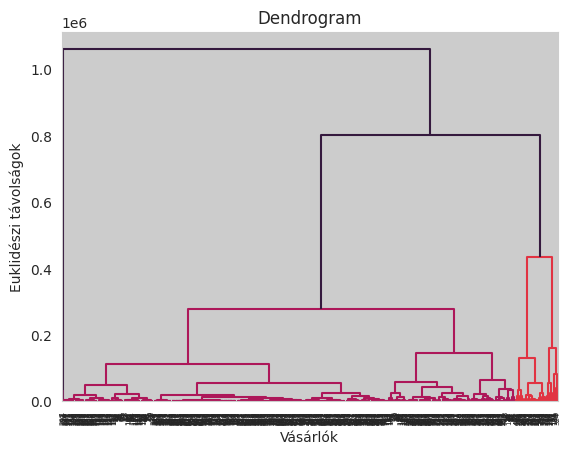

In [ ]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(merged_data, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Vásárlók')
plt.ylabel('Euklidészi távolságok')
plt.show()

Ehhez a modellhez is vehetünk 4 klasztert.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(merged_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



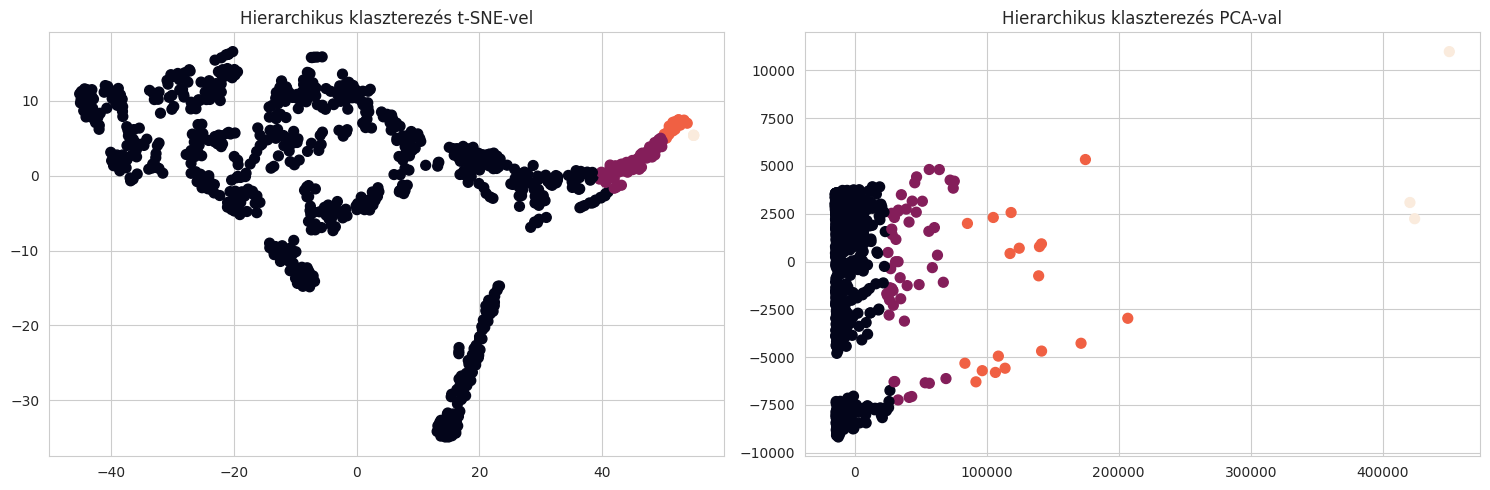

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].scatter(data_tsne[:, 0], data_tsne[:, 1], c=y_hc, s=50, cmap=c_palette)
axes[0].set_title('Hierarchikus klaszterezés t-SNE-vel')

axes[1].scatter(data_pca[:, 0], data_pca[:, 1], c=y_hc, s=50, cmap=c_palette)
axes[1].set_title('Hierarchikus klaszterezés PCA-val')

plt.tight_layout()
plt.show()

In [ ]:
temp = pd.DataFrame({
    'tsne_1': data_tsne[:, 0],
    'tsne_2': data_tsne[:, 1],
    'cluster': y_hc,
    'hover_label': hover_labels
})

temp['cluster'] = temp['cluster'].astype(str)

hex_palette = [rgb2hex(color) for color in palette]

custom_cmap = {
    '0': hex_palette[1],
    '1': hex_palette[2],
    '2': hex_palette[3],
    '3': hex_palette[4]
}

In [ ]:
fig = px.scatter(
    temp,
    x='tsne_1',
    y='tsne_2',
    color='cluster',
    hover_name='hover_label',
    color_discrete_map=custom_cmap
)

fig.update_traces(hovertemplate='%{hovertext}')
fig.show()

In [ ]:
temp2 = pd.DataFrame({
    'pca_1': data_pca[:, 0],
    'pca_2': data_pca[:, 1],
    'cluster': y_hc,
    'hover_label': hover_labels
})

temp2['cluster'] = temp2['cluster'].astype(str)

hex_palette = [rgb2hex(color) for color in palette]

custom_cmap = {
    '0': hex_palette[1],
    '1': hex_palette[2],
    '2': hex_palette[3],
    '3': hex_palette[4]
}

In [ ]:
fig = px.scatter(
    temp2,
    x='pca_1',
    y='pca_2',
    color='cluster',
    hover_name='hover_label',
    color_discrete_map=custom_cmap
)

fig.update_traces(hovertemplate='%{hovertext}')
fig.show()

In [ ]:
y_hcd = pd.DataFrame(y_hc)
y_hcd.columns = ['Cluster']
groups2 = pd.concat([labels, y_hcd], axis=1)

In [ ]:
groups2[groups2['Cluster'] == 0]

PartnerId  RFM_Score         Customer_segment          City  \
0            4       1.84  Kevésbé fontos kliensek        BRASOV   
2          124       2.90  Kevésbé fontos kliensek        BRASOV   
3          125       0.58     Elveszített kliensek        BRASOV   
4          142       2.00  Kevésbé fontos kliensek    SIGHISOARA   
5          143       3.97        Semleges kliensek        BRASOV   
..         ...        ...                      ...           ...   
801      12801       1.16     Elveszített kliensek  MOSNITA NOUA   
802      12802       1.16     Elveszített kliensek       BECLEAN   
803      12807       1.94  Kevésbé fontos kliensek  BAIA DE FIER   
804      12809       1.20     Elveszített kliensek   CLUJ NAPOCA   
805      12812       1.23     Elveszített kliensek       CRAIOVA   

    EarliestDocument LatestDocument  DaysBetween    SalesMean  SalesSum  \
0         2022-08-24     2022-12-14          112   702.400000   1404.80   
2         2022-01-14     2022-11-07          297   300.858571   2106.01   
3         2022-03-21     2022-03-21            0   445.000000    445.00   
4         2022-04-26     2022-10-17          174   397.806667   1193.42   
5         2022-01-04     2022-12-29          359   665.690714   9319.67   
..               ...            ...          ...          ...       ...   
801       2022-12-21     2022-12-21            0    76.010000     76.01   
802       2022-12-21     2022-12-21            0   810.510000    810.51   
803       2022-12-22     2022-12-22            0  1932.650000   3865.30   
804       2022-12-27     2022-12-27            0   323.530000    323.53   
805       2022-12-28     2022-12-28            0   131.820000    131.82   

    Quarter  Cluster  
0    2022Q3        0  
2    2022Q1        0  
3    2022Q1        0  
4    2022Q2        0  
5    2022Q3        0  
..      ...      ...  
801  2022Q4        0  
802  2022Q4        0  
803  2022Q4        0  
804  2022Q4        0  
805  2022Q4        0  

[735 rows x 11 columns]

In [ ]:
groups2[groups2['Cluster'] == 1]

PartnerId  RFM_Score   Customer_segment                   City  \
52         689       4.52   Legjobb kliensek              TIMISOARA   
53         690       4.80   Legjobb kliensek                 SOVATA   
63         780       4.74   Legjobb kliensek                OTOPENI   
74         954       4.79   Legjobb kliensek                   ARAD   
83        1035       4.73   Legjobb kliensek                OTOPENI   
96        1141       4.61   Legjobb kliensek                GHIRODA   
123       1804       4.50   Értékes kliensek              TIMISOARA   
124       1809       4.81   Legjobb kliensek                 BRASOV   
138       4775       4.59   Legjobb kliensek           MOSNITA NOUA   
152       5390       4.60   Legjobb kliensek            TARGU MURES   
168       5820       4.46   Értékes kliensek              BUCURESTI   
179       6015       4.55   Legjobb kliensek            TARGU MURES   
181       6050       4.83   Legjobb kliensek      ODORHEIU SECUIESC   
186       6173       4.60   Legjobb kliensek              TIMISOARA   
198       6387       3.95  Semleges kliensek                  BICAZ   
199       6437       3.91  Semleges kliensek              TIMISOARA   
204       6557       4.74   Legjobb kliensek             DUMBRAVITA   
206       6573       4.43   Értékes kliensek                  JIBOU   
207       6588       4.07   Értékes kliensek                CRAIOVA   
211       6727       4.64   Legjobb kliensek         TARGU SECUIESC   
216       6805       4.52   Legjobb kliensek            TARGU MURES   
227       7021       4.52   Legjobb kliensek                BECLEAN   
231       7128       4.66   Legjobb kliensek                FOCSANI   
246       7569       4.39   Értékes kliensek              TIMISOARA   
257       7779       3.90  Semleges kliensek                MARGINA   
262       7998       3.78  Semleges kliensek              TARGU JIU   
265       8042       3.74  Semleges kliensek              TIMISOARA   
285       8682       4.38   Értékes kliensek          TIMISU DE JOS   
298       8992       4.71   Legjobb kliensek               BISTRITA   
302       9080       4.53   Legjobb kliensek                 ZABALA   
307       9214       4.73   Legjobb kliensek      ODORHEIU SECUIESC   
314       9541       4.14   Értékes kliensek      ODORHEIU SECUIESC   
336       9833       4.58   Legjobb kliensek         MIERCUREA CIUC   
339       9866       4.72   Legjobb kliensek           MOSNITA NOUA   
364      10236       4.48   Értékes kliensek             CARANSEBES   
370      10387       4.28   Értékes kliensek              CAMPULUNG   
392      10599       4.80   Legjobb kliensek                FAGARAS   
394      10634       4.20   Értékes kliensek               ZARNESTI   
396      10648       3.41  Semleges kliensek           NEGRESTI OAS   
399      10691       4.60   Legjobb kliensek            TARGU MURES   
400      10696       4.27   Értékes kliensek        SANNICOLAU MARE   
408      10771       4.83   Legjobb kliensek                  TURDA   
424      10899       4.81   Legjobb kliensek            TARGU MURES   
445      11119       4.91   Legjobb kliensek                   ARAD   
461      11255       4.85   Legjobb kliensek                 HARLAU   
482      11444       4.58   Legjobb kliensek  DROBETA TURNU SEVERIN   
533      11797       4.06   Értékes kliensek              TIMISOARA   
564      11999       3.85  Semleges kliensek                 GALATI   
579      12083       4.86   Legjobb kliensek         MIERCUREA CIUC   
619      12215       4.67   Legjobb kliensek                  BEIUS   

    EarliestDocument LatestDocument  DaysBetween    SalesMean  SalesSum  \
52        2022-01-06     2022-12-21          349  1269.998065  39369.94   
53        2022-01-10     2022-12-27          351   783.558077  40745.02   
63        2022-01-05     2022-12-13          342   440.040263  33443.06   
74        2022-04-14     2022-12-28          258  1257.218936  59089.29   
83      

In [ ]:
groups2[groups2['Cluster'] == 2]

PartnerId  RFM_Score  Customer_segment               City  \
9          162       4.92  Legjobb kliensek             SOVATA   
10         193       4.58  Legjobb kliensek          TIMISOARA   
17         316       4.96  Legjobb kliensek          TIMISOARA   
20         342       4.77  Legjobb kliensek     MIERCUREA CIUC   
37         524       4.90  Legjobb kliensek       PIATRA NEAMT   
40         554       4.98  Legjobb kliensek            CRAIOVA   
48         650       4.49  Értékes kliensek          PETROSANI   
93        1106       4.90  Legjobb kliensek            SUCEAVA   
112       1387       4.80  Legjobb kliensek        CLUJ NAPOCA   
133       4518       4.82  Legjobb kliensek          TARGU JIU   
180       6027       4.84  Legjobb kliensek          TIMISOARA   
184       6130       4.85  Legjobb kliensek  CLUJ Unknown City   
188       6246       4.88  Legjobb kliensek          TARGU JIU   
194       6326       4.52  Legjobb kliensek          TIMISOARA   
271       8362       4.83  Legjobb kliensek         CARANSEBES   
277       8456       4.89  Legjobb kliensek             SINAIA   
282       8655       4.98  Legjobb kliensek     MIERCUREA CIUC   
324       9676       4.84  Legjobb kliensek       MOLDOVA NOUA   

    EarliestDocument LatestDocument  DaysBetween    SalesMean   SalesSum  \
9         2022-01-04     2022-12-27          357  1216.920093  131427.37   
10        2022-02-01     2022-12-19          321  1976.872105   75121.14   
17        2022-01-03     2022-12-28          359   551.989097   85558.31   
20        2022-01-03     2022-12-19          350  1296.181429   90732.70   
37        2022-01-07     2022-12-27          354  1345.041098  110293.37   
40        2022-01-03     2022-12-30          361  1326.078220  156477.23   
48        2022-01-11     2022-12-22          345  2616.808333   78504.25   
93        2022-01-03     2022-12-28          359  1227.491972   87151.93   
112       2022-01-05     2022-12-22          351  1214.727719   69239.48   
133       2022-01-03     2022-12-19          350  1007.468704  108806.62   
180       2022-01-06     2022-12-23          351  1655.506515  109263.43   
184       2022-01-25     2022-12-27          336  1838.718000  110323.08   
188       2022-01-05     2022-12-22          351   954.178265   93509.47   
194       2022-01-20     2022-12-27          341  3280.757667   98422.73   
271       2022-01-10     2022-12-28          352  1775.577547   94105.61   
277       2022-01-04     2022-12-27          357  1174.602778   84571.40   
282       2022-01-05     2022-12-29          358   439.281988   70724.40   
324       2022-01-03     2022-12-27          358  2309.360172  133942.89   

    Quarter  Cluster  
9    2022Q2        2  
10   2022Q2        2  
17   2022Q1        2  
20   2022Q1        2  
37   2022Q3        2  
40   2022Q4        2  
48   2022Q1        2  
93   2022Q1        2  
112  2022Q3        2  
133  2022Q3        2  
180  2022Q3        2  
184  2022Q1        2  
188  2022Q1        2  
194  2022Q2        2  
271  2022Q2        2  
277  2022Q3        2  
282  2022Q2        2  
324  2022Q1        2

In [ ]:
groups2[groups2['Cluster'] == 3]

PartnerId  RFM_Score  Customer_segment         City EarliestDocument  \
1          113       4.69  Legjobb kliensek          DEJ       2022-01-06   
92        1098       4.97  Legjobb kliensek    BUCURESTI       2022-01-03   
267       8191       4.78  Legjobb kliensek  TARGU MURES       2022-01-05   

    LatestDocument  DaysBetween    SalesMean   SalesSum Quarter  Cluster  
1       2022-12-20          348  6891.433333  310114.50  2022Q2        3  
92      2022-12-28          359   776.868359  307639.87  2022Q3        3  
267     2022-12-19          348  4567.217083  328839.63  2022Q3        3

### **DBSCAN klaszterezés**

A DBSCAN algoritmusnál előre nem kell meghatározni a klaszterszámot, a modell határozza meg.

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=10, min_samples=5)
y_dbscan = dbscan.fit_predict(merged_data)

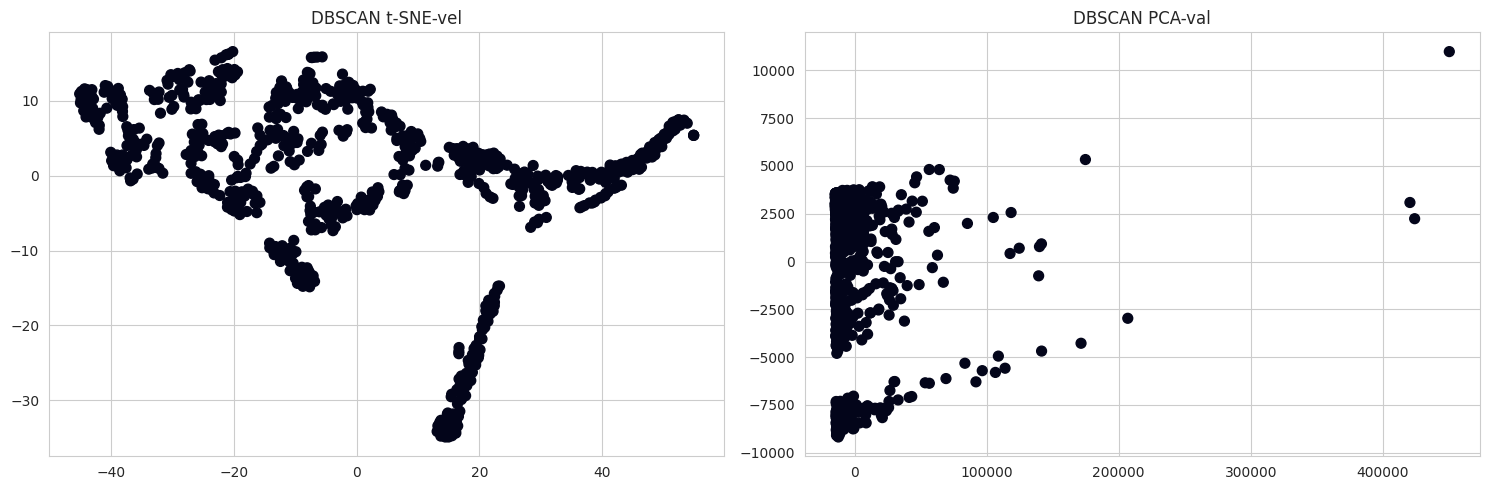

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].scatter(data_tsne[:, 0], data_tsne[:, 1], c=y_dbscan, s=50, cmap=c_palette)
axes[0].set_title('DBSCAN t-SNE-vel')

axes[1].scatter(data_pca[:, 0], data_pca[:, 1], c=y_dbscan, s=50, cmap=c_palette)
axes[1].set_title('DBSCAN PCA-val')

plt.tight_layout()
plt.show()

Különböző hiperparaméter finomhangolási beállítások után sem alakított ki a modell értelmezhető klasztereket, így levonhatjuk a következtetést, hogy erre az adatbázisra nem működik jól.

### **Spectral klaszterezés**

**Silhouette score**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:420: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:420: ConvergenceWarning:

Number 

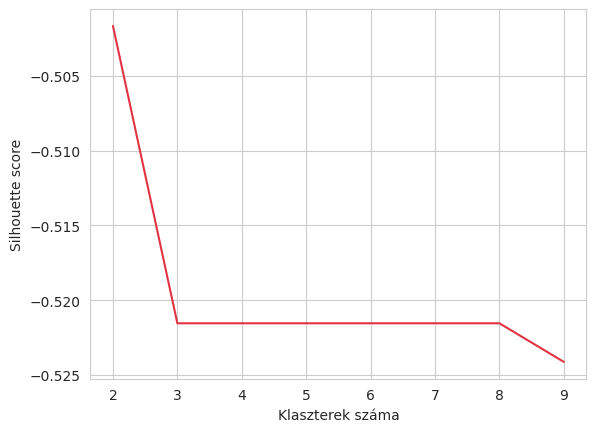

In [ ]:
from sklearn.cluster import SpectralClustering
silhouette_scores = []
for n_clusters in range(2, 10):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf')
    cluster_labels = spectral.fit_predict(merged_data)
    silhouette_scores.append(silhouette_score(merged_data, cluster_labels))
plt.plot(range(2, 10), silhouette_scores, color=palette[3])
plt.xlabel('Klaszterek száma')
plt.ylabel('Silhouette score')
plt.show()

Negatív score-ok nem sok jót jelentenek, a modell nem fog tudni jó klasztereket létrehozni.

### **Gaussian Mixture Model**

**Silhouette score**

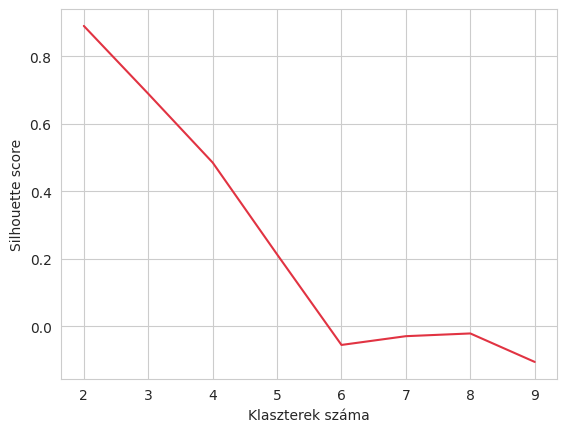

In [ ]:
from sklearn.mixture import GaussianMixture
silhouette_scores = []
for n_clusters in range(2, 10):
    gauss = GaussianMixture(n_components=n_clusters)
    cluster_labels = gauss.fit_predict(merged_data)
    silhouette_scores.append(silhouette_score(merged_data, cluster_labels))
plt.plot(range(2, 10), silhouette_scores, color=palette[3])
plt.xlabel('Klaszterek száma')
plt.ylabel('Silhouette score')
plt.show()

Utolsó modellként, a Gaussian Mixture Modelt is kipróbáljuk 3 komponensre.

In [ ]:
gauss = GaussianMixture(n_components=3)
y_gauss = gauss.fit_predict(merged_data)

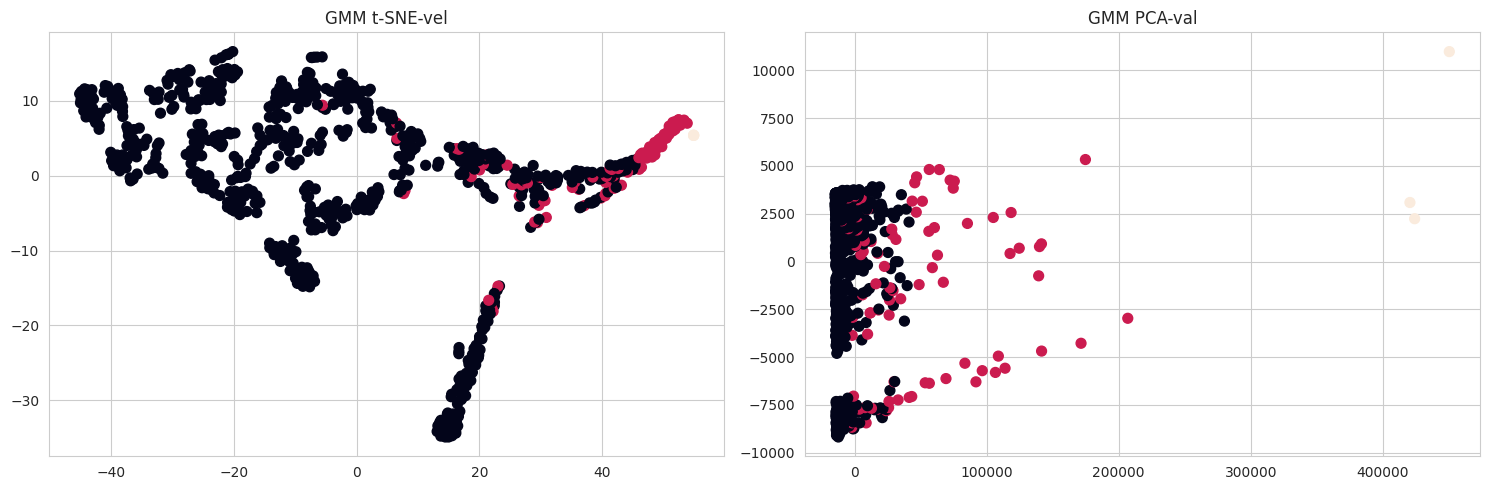

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].scatter(data_tsne[:, 0], data_tsne[:, 1], c=y_gauss, s=50, cmap=c_palette)
axes[0].set_title('GMM t-SNE-vel')

axes[1].scatter(data_pca[:, 0], data_pca[:, 1], c=y_gauss, s=50, cmap=c_palette)
axes[1].set_title('GMM PCA-val')

plt.tight_layout()
plt.show()

Nem jönnek létre egymástól szépen elkülöníthető klaszterek.

## **Modell Kiválasztása és Értékelése**

A modellezési folyamat eredményeit tekintve, levonhatjuk a következtetést, hogy a **Hierarchikus klaszterezési algoritmus** hozta létre a legjobb csoportokra, **4 klaszter** az optimális szám.

**Adattisztítási folyamat** rövid leírása:

* Adatbázis alapjellemzőinek áttekintése
* Ellenőrzés, hogy vannak-e duplikált sorok
* Oszlopok sorravevéve a következők ellenőrzése és javítása: duplikált értékek, hiányzó értékek, adattípusok, nem odaillő értékek eltávolítása
* Dimenziókhoz releváns vizualizációk

A választott algoritmus: **Hierarchikus Klaszterezés**

Optimális klaszterszám: **4 klaszter**

* 5 ügyfélcsoportot még könnyen tud kezelni egy kisebb marketinges csapat is

**Okai:**

* Átláthatóan kirajzolódnak és elválasztódnak egymástól a klaszterek
* Nem hoz létre egy annyira nagy csoportot mint a KMeans (KMeans-nél nem lett volna az 5 klaszter optimális a metrikák szerint)
* Egy csoporton belüli tagok hasonlítanak egymáshoz sok szempontból, tehát jó munkát végzett az algoritmus

**Előnyök:**

* A dendrogram betekintést nyújt az optimális klaszterszámokba
* Könnyen implementálható:  nem igényel bonyolult paraméter-finomhangolást vagy iteratív optimalizálási folyamatokat
* Jól működik kis adatbázisokra: hatékony kis- és közepes méretű adatállományok esetében, ahol részletes elemzés és vizualizáció lehetséges

**Hátrányok:**

* Skálázhatósági problémák:  számításigényes és memóriaigényes lehet
* Nehézség a megfelelő vágási pont kiválasztásában: a vágási pont kiválasztása néha szubjektív lehet, és szükség lehet területbeli ismeretekre vagy további validálási technikákra
* Nem alkalmas minden típusú adatra: nem mindig működik jól olyan adatokkal, amelyeknek nincs hierarchikus természetük, vagy ha a klaszterek nincsenek jól elkülönítve




### **Klaszterek értelmezése és leírása + javasolt marketing stratégiák**

In [ ]:
groups2[groups2['Cluster'] == 0].head()

PartnerId  RFM_Score         Customer_segment        City EarliestDocument  \
0          4       1.84  Kevésbé fontos kliensek      BRASOV       2022-08-24   
2        124       2.90  Kevésbé fontos kliensek      BRASOV       2022-01-14   
3        125       0.58     Elveszített kliensek      BRASOV       2022-03-21   
4        142       2.00  Kevésbé fontos kliensek  SIGHISOARA       2022-04-26   
5        143       3.97        Semleges kliensek      BRASOV       2022-01-04   

  LatestDocument  DaysBetween   SalesMean  SalesSum Quarter  Cluster  
0     2022-12-14          112  702.400000   1404.80  2022Q3        0  
2     2022-11-07          297  300.858571   2106.01  2022Q1        0  
3     2022-03-21            0  445.000000    445.00  2022Q1        0  
4     2022-10-17          174  397.806667   1193.42  2022Q2        0  
5     2022-12-29          359  665.690714   9319.67  2022Q3        0

**Klaszter 0:** Alkalmi kliensek

**Leírás:** Vannak ebben a klaszterben ügyfelek akik csak egyszer vagy csak néhányszor vásároltak és kis összegekre. Gyenge FRM score-ral rendelkeznek, nem igazán járulnak hozzá a vállalati érték növekedéséhez.

**Javasolt stratégia:** Meggyőző, bevonzó marketing stratégiával lehetne őket megközelíteni, mivel nem ismerik annyira a vállalatot, minél többet mutatni abból, hogy milyen előnyökkel járna számukra ha hűséges vásárlókká válnának.

In [ ]:
groups2[groups2['Cluster'] == 1].head()

PartnerId  RFM_Score  Customer_segment       City EarliestDocument  \
52        689       4.52  Legjobb kliensek  TIMISOARA       2022-01-06   
53        690       4.80  Legjobb kliensek     SOVATA       2022-01-10   
63        780       4.74  Legjobb kliensek    OTOPENI       2022-01-05   
74        954       4.79  Legjobb kliensek       ARAD       2022-04-14   
83       1035       4.73  Legjobb kliensek    OTOPENI       2022-01-25   

   LatestDocument  DaysBetween    SalesMean  SalesSum Quarter  Cluster  
52     2022-12-21          349  1269.998065  39369.94  2022Q2        1  
53     2022-12-27          351   783.558077  40745.02  2022Q4        1  
63     2022-12-13          342   440.040263  33443.06  2022Q3        1  
74     2022-12-28          258  1257.218936  59089.29  2022Q3        1  
83     2022-12-28          337  1286.601026  50177.44  2022Q4        1

**Klaszter 1:** Rendszeres ügyfelek

**Leírás:** Ebben a csoportban vannak értékes és semleges kliensek is, viszonylag sokszor válaszolnak, közepes nagyságű összvásárlási értékkel rendelkeznek, és 4-es körüli FRM score-ral.

**Javasolt stratégia:** Náluk kombinálni érdemes a személyreszabottabb ajánlatokat az általános új úgyfél megszerző stratégiával, mert azért a teljesen személyreszabott bánásmódhoz túl sokan tartoznak ebbe a csoportba.

In [ ]:
groups2[groups2['Cluster'] == 2].head()

PartnerId  RFM_Score  Customer_segment            City EarliestDocument  \
9         162       4.92  Legjobb kliensek          SOVATA       2022-01-04   
10        193       4.58  Legjobb kliensek       TIMISOARA       2022-02-01   
17        316       4.96  Legjobb kliensek       TIMISOARA       2022-01-03   
20        342       4.77  Legjobb kliensek  MIERCUREA CIUC       2022-01-03   
37        524       4.90  Legjobb kliensek    PIATRA NEAMT       2022-01-07   

   LatestDocument  DaysBetween    SalesMean   SalesSum Quarter  Cluster  
9      2022-12-27          357  1216.920093  131427.37  2022Q2        2  
10     2022-12-19          321  1976.872105   75121.14  2022Q2        2  
17     2022-12-28          359   551.989097   85558.31  2022Q1        2  
20     2022-12-19          350  1296.181429   90732.70  2022Q1        2  
37     2022-12-27          354  1345.041098  110293.37  2022Q3        2

**Klaszter 2:** Hűséges kliensek

**Leírás:** Az ehhez a csoporthoz tartozó ügyfelek egész év folyamán vásároltak, nagy összegekre, a vállalattól. Magas az FRM score-juk értéke is.

**Javasolt stratégia:** Fontos kiemelt figyelemmel kezelni ezeket a klienseket, és ügyfélmegtartó stratégiákat alkalmazni. Őket már nem kell megnyerni, de kedvezményekkel, személyesített ajánlatokkal érdemes velük megtartani velük a jó üzleti partner kapcsolatot.

In [ ]:
groups2[groups2['Cluster'] == 3].head()

PartnerId  RFM_Score  Customer_segment         City EarliestDocument  \
1          113       4.69  Legjobb kliensek          DEJ       2022-01-06   
92        1098       4.97  Legjobb kliensek    BUCURESTI       2022-01-03   
267       8191       4.78  Legjobb kliensek  TARGU MURES       2022-01-05   

    LatestDocument  DaysBetween    SalesMean   SalesSum Quarter  Cluster  
1       2022-12-20          348  6891.433333  310114.50  2022Q2        3  
92      2022-12-28          359   776.868359  307639.87  2022Q3        3  
267     2022-12-19          348  4567.217083  328839.63  2022Q3        3

**Klaszter 3:** Top kliensek

**Leírás:** Ez a csoport a vállalat 3 olyan ügyfelét tartalmazza, összességében a legtöbbet vásároltak tőlük, láthatjuk azt is, hogy a teljes év leforgása alatt vásároltak folyamatosan. Magas, majdnem tökéletes az FRMM értékük.

**Javasolt stratégia:** Ők a legaktívabb és leghűségesebb kliensek, ezért fontos a személyes kapcsolattartás velük, hűség alapú promóciók megadása, személyreszabott igényeik mindenképpeni kielégítése.

**Összesítő elemzés:**

-A forgalmas dátumok változatosságából elmondhatjuk, hogy nem szezonális termékekről van szó, ezért nem kell specifikus periódusokra koncentrálni az eladásokkal és reklámokkal

-A legtöbb legtöbbször vásárló székhely Erdélyben található (+Bukarest, ami még nagyon fontos)

-Az év első 3 negyedévében jelentősen növekedett az árbevétel, utána az év végére visszacsökkent, lehetne új stratégiát kidolgozni erre az idő periódusra, ha ez egy szezonális visszaesés, viszont, ha ez a periódus után is csökkenni fog, akkor lehet szükséges több ügyfél interakció, szorosabb ügyfélkapcsolat (október környékén kezdett inkább csökkenni )

-Legnagyobb pénz mennyiségben  Bukarestből vásárolnak (meg más a nagyobb városokban nagyobb a mérték). Hasonló jellegű városokban hasznos lenne, ha mégtöbb embert el tudnának érni, mert itt hajlandóbbak többet fizetni, többet költeni
   
-Mivel magas a korreláció a gyakran vásárló ügyfelek és az összeg nagysága között, ezért több ügyfelet érdemes “törzsvendégesíteni”, koncentrálni a meglévő ügyfelekre és nekik új ajánlatokat tenni
-Nagy számban vannak kevésbé fontos és semleges kliensek , fontos lépés lenne velük újra kapcsolatba lépni, hogy lássuk ki tudna újra aktívan vásárló kliense lenni a vállalkozásnak.